In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

# **数据加载**

In [2]:
df_train = pd.read_csv("~/.kaggle/competitions/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("~/.kaggle/competitions/house-prices-advanced-regression-techniques/test.csv")
df_allX = pd.concat([df_train.loc[:,'MSSubClass':'SaleCondition'],
                   df_test.loc[:,'MSSubClass':'SaleCondition']])
df_allX = df_allX.reset_index(drop=True)

read_csv() 中如何处理 NA：

- `pd.read_csv(file,... na_values=None, keep_default_na=True, ...)`
- na_values: 遇到该参数指定的字符时，即解析为 np.NaN(float型)，无论此列是数值型orobject型。
    - 默认值：`'', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan','1.#IND', '1.#QNAN', 'N/A', 'NA', 'NULL', 'NaN', 'nan'`.
- keep_default_na
    - True：将csv 文件中的数字or字符串与 na_values 的 default 值进行匹配，命中即解析为 np.NaN
    - False：
        - na_values=[...] ：与自定义的 na_values 匹配，命中即解析为 np.NaN
        - na_values不赋值：不解析相关字符串，保留为原字符串，副作用：会把数值型的feature错误的认成 object 型 —— so，不可取

In [3]:
print(df_train.shape,df_test.shape,df_allX.shape) # df_allX 少了 Id 和 SalePrice 两列

(1460, 81) (1459, 80) (2919, 79)


## 基础统计

In [4]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## 特征分类

**特征从2个维度进行分类：**

| |**数值量（numeric）**|**字符量（object）**|
|:---|:---|:---|
|**连续型(Continuous)**|距离、面积……| 无 |
|**离散型(discrete)<br>类型量(categorical)**|楼层、年份、<br>数值化后的字符量……|房型、材料种类……|


* 通常需要将离散的字符量 --> 离散的数值量
* pandas.read_csv() 得到的 dataframe 的column类型与变量的对应关系：
    * int,float —— 数值量（连续和离散）
    * object    —— 字符量（离散）
        * 虽然 column 是 object的，但具体里面的值是 'str'、'float'(NA值是float）


In [5]:
# 数值量特征
feats_numeric  = df_allX.dtypes[df_allX.dtypes != "object"].index.values
#feats_numeric = [attr for attr in df_allX.columns if df_allX.dtypes[attr] != 'object']

# 字符量特征
feats_object = df_allX.dtypes[df_allX.dtypes == "object"].index.values
#feats_object = [attr for attr in df_allX.columns if df_allX.dtypes[attr] == 'object']
#feats_object = df_train.select_dtypes(include = ["object"]).columns

print(feats_numeric.shape,feats_object.shape)

(36,) (43,)


总共79个特征，pandas自动识别的 36个数值量，43个字符量。

In [6]:
# 离散的数值量，需要人工甄别
feats_numeric_discrete  = ['MSSubClass','OverallQual','OverallCond'] # 户型、整体质量打分、整体条件打分 —— 文档中明确定义的类型量
feats_numeric_discrete += ['TotRmsAbvGrd','KitchenAbvGr','BedroomAbvGr','GarageCars','Fireplaces'] # 房间数量
feats_numeric_discrete += ['FullBath','HalfBath','BsmtHalfBath','BsmtFullBath'] # 外国人这么爱洗澡？搞这么多浴室
feats_numeric_discrete += ['MoSold','YrSold'] # 年、月，这些不看成离散的应该也行

# 连续型特征
feats_continu = feats_numeric.copy()
# 离散型特征
feats_discrete = feats_object.copy()

for f in feats_numeric_discrete:
    feats_continu = np.delete(feats_continu,np.where(feats_continu == f))
    feats_discrete = np.append(feats_discrete,f)

print(feats_continu.shape,feats_discrete.shape)

(22,) (57,)


经过处理，得到 22个连续型特征，57个离散型特征

## 基本分布(scatter)

In [7]:
def plotfeats(frame,feats,kind,cols=4):
    rows = int(np.ceil((len(feats))/cols))
    if rows==1 and len(feats)<cols:
        cols = len(feats)
    #print("输入%d个特征，分%d行、%d列绘图" % (len(feats), rows, cols))
    if kind == 'hs': #hs:hist and scatter
        fig, axes = plt.subplots(nrows=rows*2,ncols=cols,figsize=(cols*5,rows*10))
    else:
        fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(cols*5,rows*5))
        if rows==1 and cols==1:
            axes = np.array([axes])
        axes = axes.reshape(rows,cols) # 当 rows=1 时，axes.shape:(cols,)，需要reshape一下
    i=0
    for f in feats:
        #print(int(i/cols),i%cols)
        if kind == 'hist':
            #frame.hist(f,bins=100,ax=axes[int(i/cols),i%cols])
            frame.plot.hist(y=f,bins=100,ax=axes[int(i/cols),i%cols])
        elif kind == 'scatter':
            frame.plot.scatter(x=f,y='SalePrice',ylim=(0,800000), ax=axes[int(i/cols),i%cols])
        elif kind == 'hs':
            frame.plot.hist(y=f,bins=100,ax=axes[int(i/cols)*2,i%cols])
            frame.plot.scatter(x=f,y='SalePrice',ylim=(0,800000), ax=axes[int(i/cols)*2+1,i%cols])
        elif kind == 'box':
            frame.plot.box(y=f,ax=axes[int(i/cols),i%cols])
        elif kind == 'boxp':
            sns.boxplot(x=f,y='SalePrice', data=frame, ax=axes[int(i/cols),i%cols])
        i += 1
    plt.show()

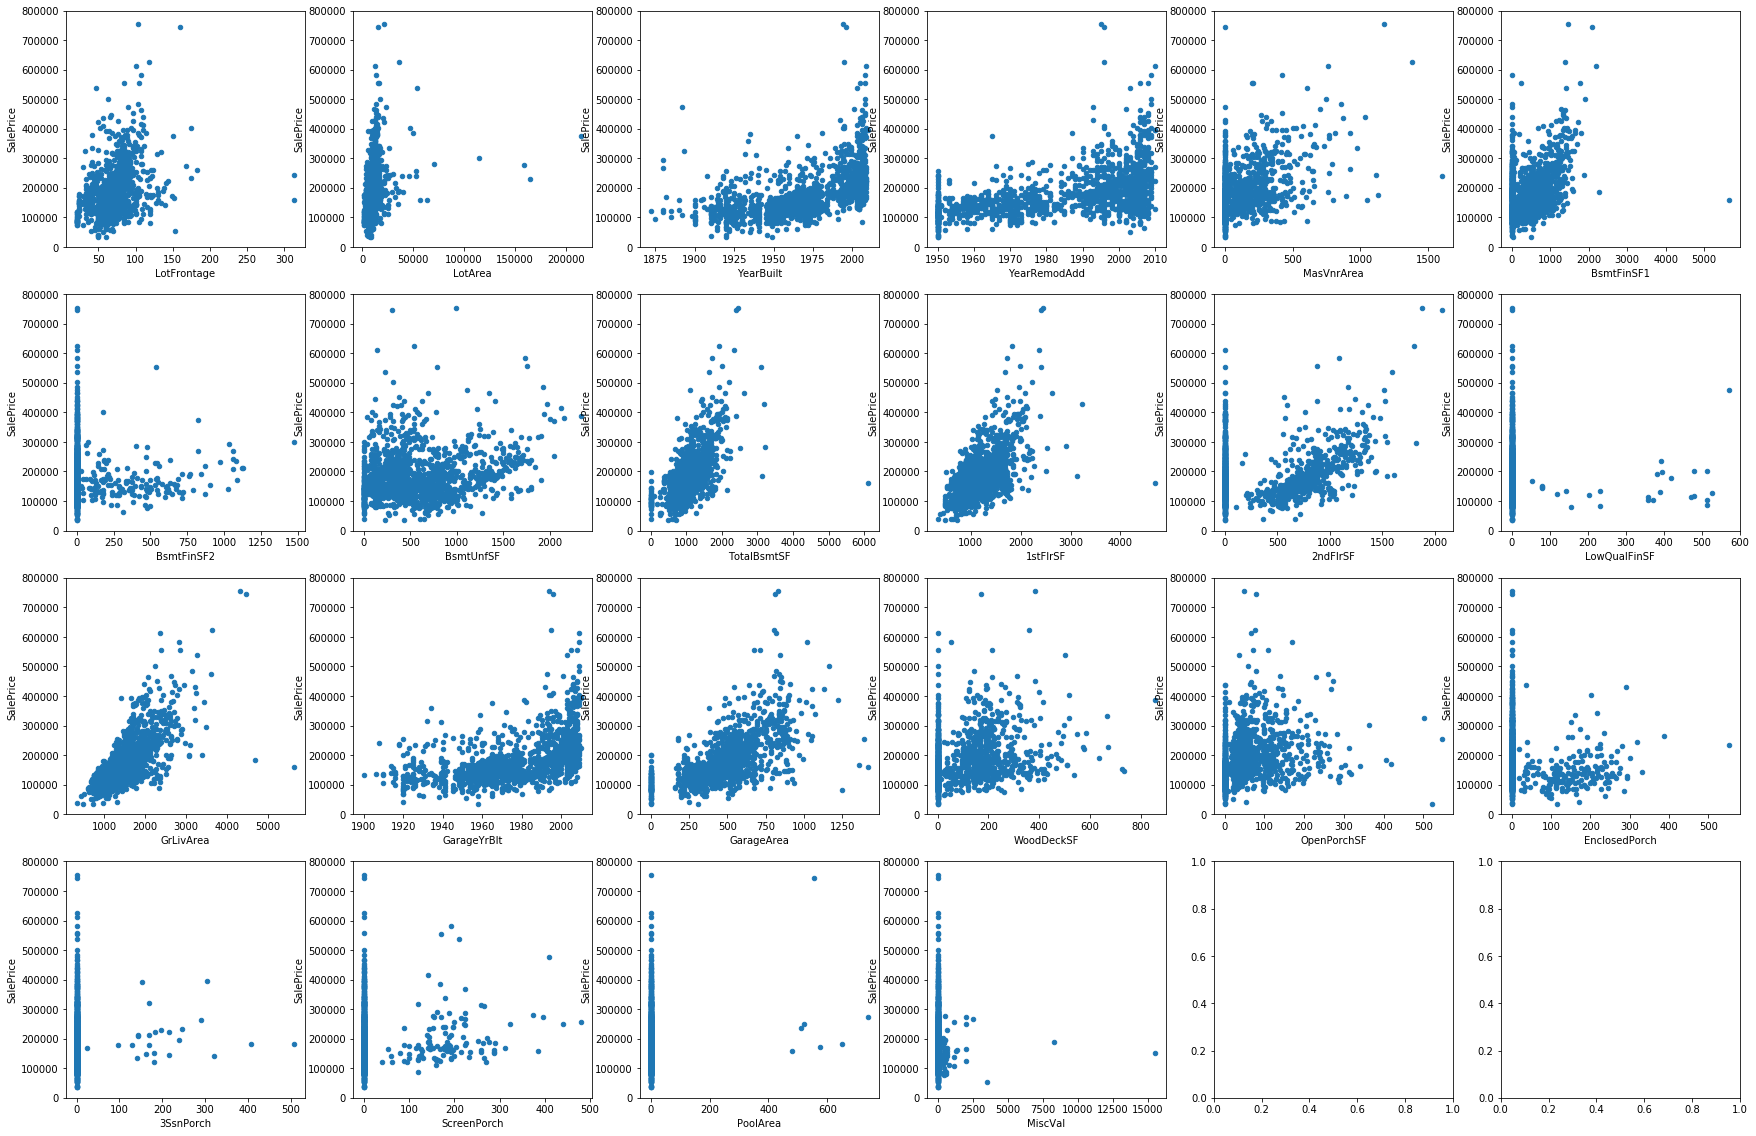

In [8]:
plotfeats(df_train,feats_continu,kind='scatter',cols=6)

分析上图：

- LotFrontage、LotArea、GrLivArea、1stFlrSF、2stFlrSF、GarageArea、BsmtFinSF1、TotalBsmtSF： 这几个面积和距离和售价呈明显正相关趋势
    - LotFrontage：房子到街道的距离，大多在50-100英尺（15-30米），距离远的是不是大多是豪宅？躲在山林深处……
    - LotArea：占地面积（包括房屋、花园、前后院……），均值是10516平方英尺（900+平方米），向往啊……
    - GrLivArea：地面以上整体面积
    - 1stFlrSF、2stFlrSF： 第1、 2层建筑面积
    - GarageArea：车库面积
    - BsmtFinSF1、BsmtFinSF2、TotalBsmtSF：地下室面积，很多房子还有第2个地下室
- YearBuilt、YearRemodAdd、GarageYrBlt：从图中可以看出，建造年限对售价虽正相关，但坡度较小，关联度没有上面几个因素大，早点、晚点售价差不多

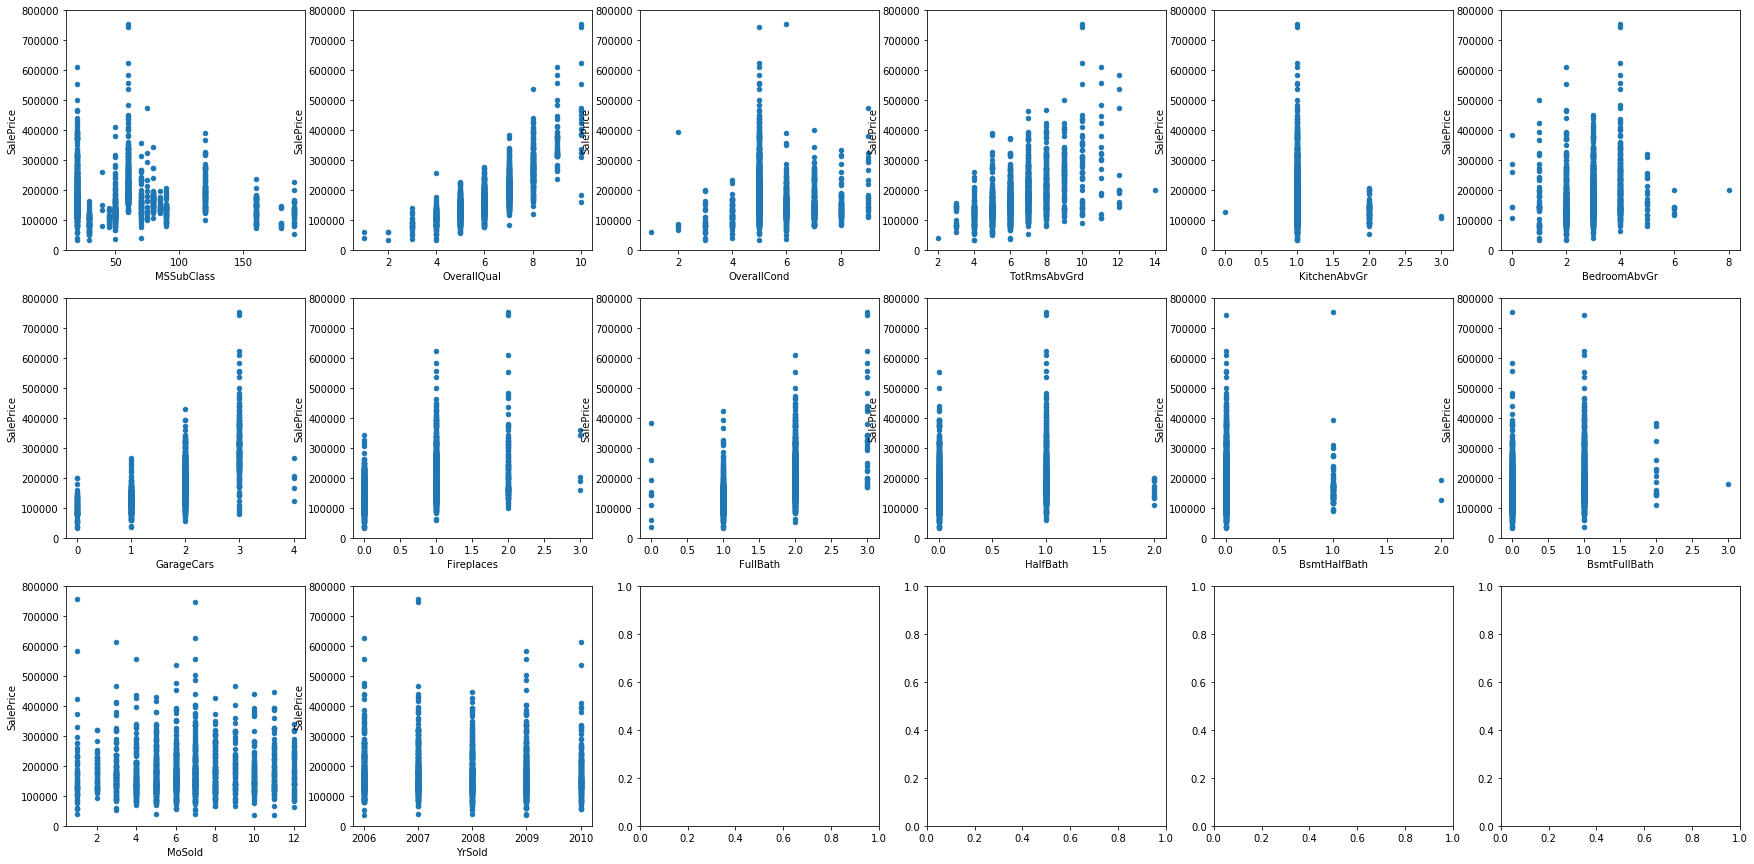

In [9]:
plotfeats(df_train,feats_numeric_discrete,kind='scatter',cols=6)

分析上图：

- MSSubClass：户型，典型的离散型特征，只不过数据提供者已经帮我们数值化了，说明文件中的有详细解释
    - 20/30/40: 单层（1-STORY）建筑，英语里楼层是 storey，美国简化为 story
    - 45/50:1-1/2 story，应该是带阁楼吧，我猜
    - ……
- OverallQual、OverallCond：房屋材料、新旧度、condition等的整体打分 —— 这个因为是人为打分，有可能存在给售价高的打高分，所以需要持怀疑态度
- TotRmsAbvGrd、GarageCars：房间数量、车库容量，可以看出和售价正相关
- YrSold、MoSold：卖出的年、月，都是06年～10年的数据，只有卖出才有真实售价嘛，这两个特征和售价我觉得是没有关联的，可以考虑删除。
- 其他的特征看不出啥明显趋势

# **数据分析**

**knowing your data is the most difficult thing in data science**

下面开始分析数据，争取用一些图来挖掘数据中隐藏的信息，为数据处理提供依据。

主要内容包括：

- 正态性分析：使用 hist（直方图）和 scatter（散点图）展示
- 分散度分析：使用 box（箱线图）展示
- 方差齐次分析：
- 方差分析： 使用 bar（柱状图）展示
- 协方差分析：使用 heatmap（热图）展示

非常感谢 matplotlib 和 seaborn，提供了简单、高效的绘图。

## 正态性检验

常用的正态性检验方法有：

* 正态概率纸法
* 夏皮罗维尔克检验法(Shapiro-Wilktest)
* 科尔莫戈罗夫检验法
* 偏度-峰度检验法等 —— 下文使用

### 偏离度分析(hist|scatter)

**skewness:偏度、偏态、偏态系数**

* 统计数据分布偏斜方向和程度的度量，是统计数据分布非对称程度的数字特征。
* 表征概率分布密度曲线相对于平均值不对称程度的特征数
* 偏离度是某一特征（即：某一列）自己的特性，不同于相关性（某两列之间）特性

In [10]:
# SalePrice 的偏离度
df_train.skew()['SalePrice']

1.8828757597682129

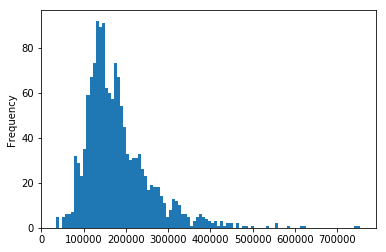

In [11]:
#df_train.plot(kind='hist',y='SalePrice',bins=100)
df_train['SalePrice'].plot(kind='hist',y='SalePrice',bins=100) # 为了和下面的图做对比才使用这行的
#sns.distplot(df_train['SalePrice'], fit='norm');
#plt.hist(df_train['SalePrice'],bins=100)

分析上图：

直方图上看非正态，有可能是数据收集的不完整，也有可能本身就不是正态分布的，收集再多的数据也是非正态的，说不定它原本就是卡方分布呢？
—— 至于是哪种，不知道，留给科学家吧。

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

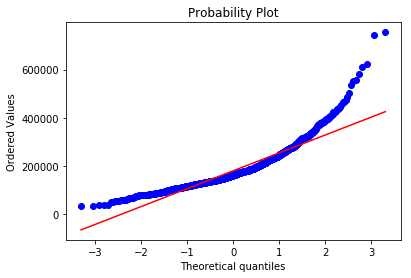

In [12]:
stats.probplot(df_train['SalePrice'], plot=plt)

通过取 log 可以纠偏，但对于本预测任务似乎没什么帮助，难道要改为预测 log 值？最后再反计算一下？没必要吧。

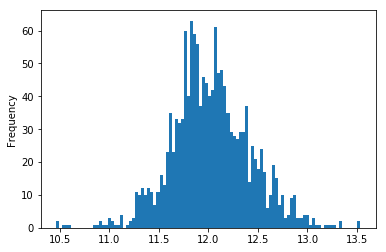

In [13]:
df_train['SalePrice'].apply(lambda x: np.log1p(x)).plot(kind='hist',y='SalePrice',bins=100)

In [14]:
# 计算各列自己的偏离度
skewed = df_allX[feats_numeric].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
#skewed = df_allX[feats_numeric].skew().sort_values(ascending=False)
skewed[:10]

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.145323
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.929996
dtype: float64

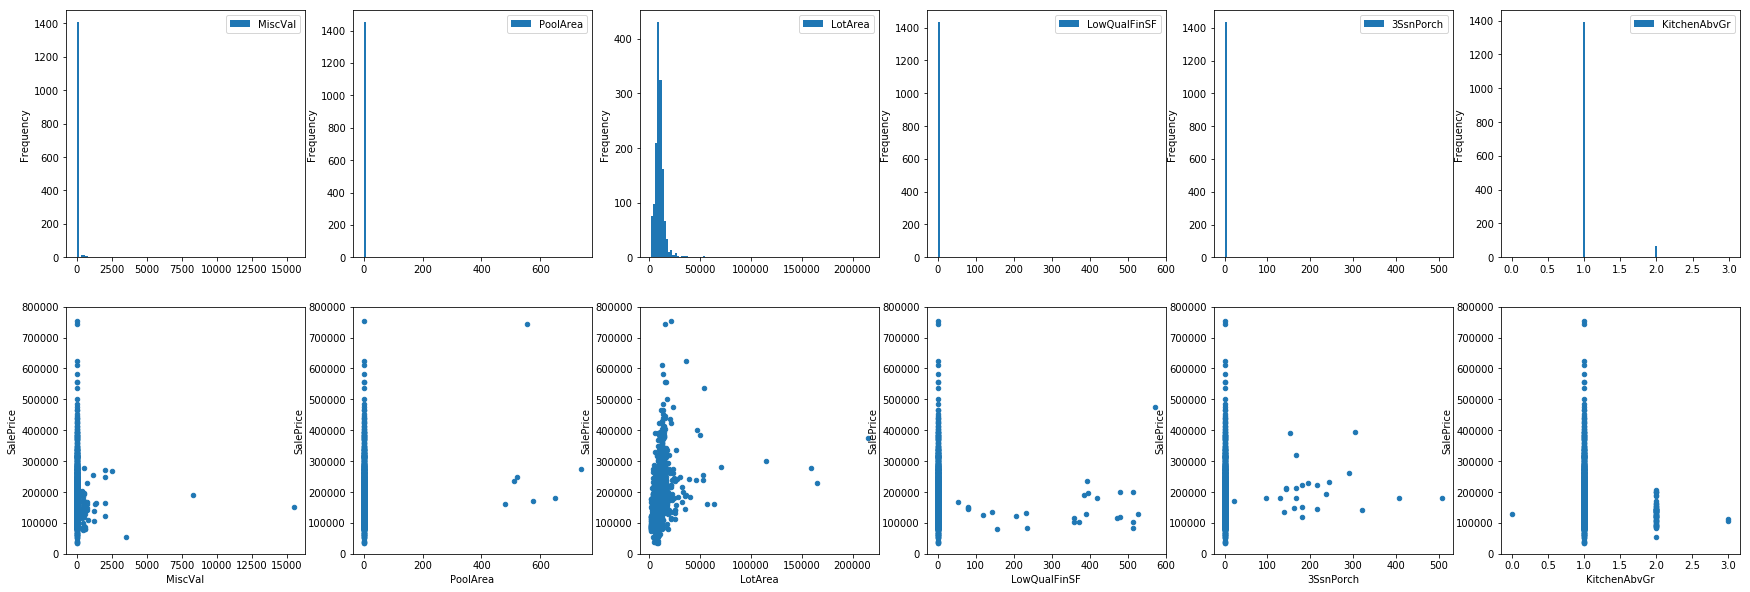

In [15]:
# 用直方图和散点图（SalePrice之间）对比展示偏离度
plotfeats(df_train,skewed[:6].index,kind='hs',cols=6)

### 峰度分析(hist|scatter)

* kurtosis,peakedness —— 峰度、峰态系数。
* 表征概率密度分布曲线在平均值处峰值高低的特征数。
* 峰度是和正态分布相比较而言统计量，反映了峰部的尖度。
* 峰度大于三，峰的形状比较尖，比正态分布峰要陡峭。
* 可用峰度来检验分布的正态性。
* 在实际应用中，通常将峰度值做减3处理，使得正态分布的峰度0。

In [16]:
df_train.kurt()['SalePrice']

6.536281860064529

In [17]:
# 计算各列自己的峰度
kurted = df_allX[feats_numeric].kurt().sort_values(ascending=False)
kurted[:10]

MiscVal          564.074582
PoolArea         298.633144
LotArea          264.952310
LowQualFinSF     174.932812
3SsnPorch        149.409834
EnclosedPorch     28.377909
KitchenAbvGr      19.777937
BsmtFinSF2        18.836540
ScreenPorch       17.776704
BsmtHalfBath      14.848079
dtype: float64

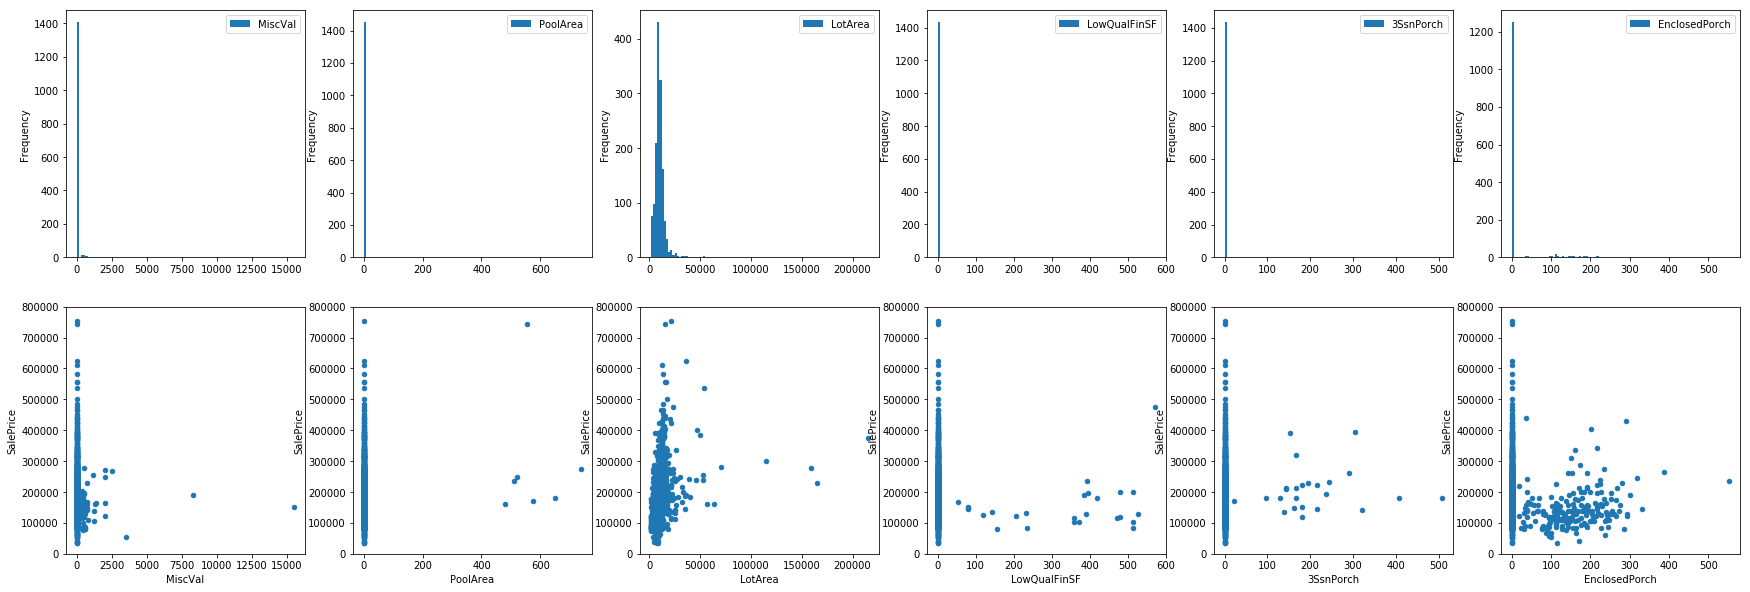

In [18]:
# 用直方图和散点图（SalePrice之间）对比展示峰度
plotfeats(df_train,kurted[:6].index,kind='hs',cols=6)

## 分散度分析(box)

### 特征本身分散度

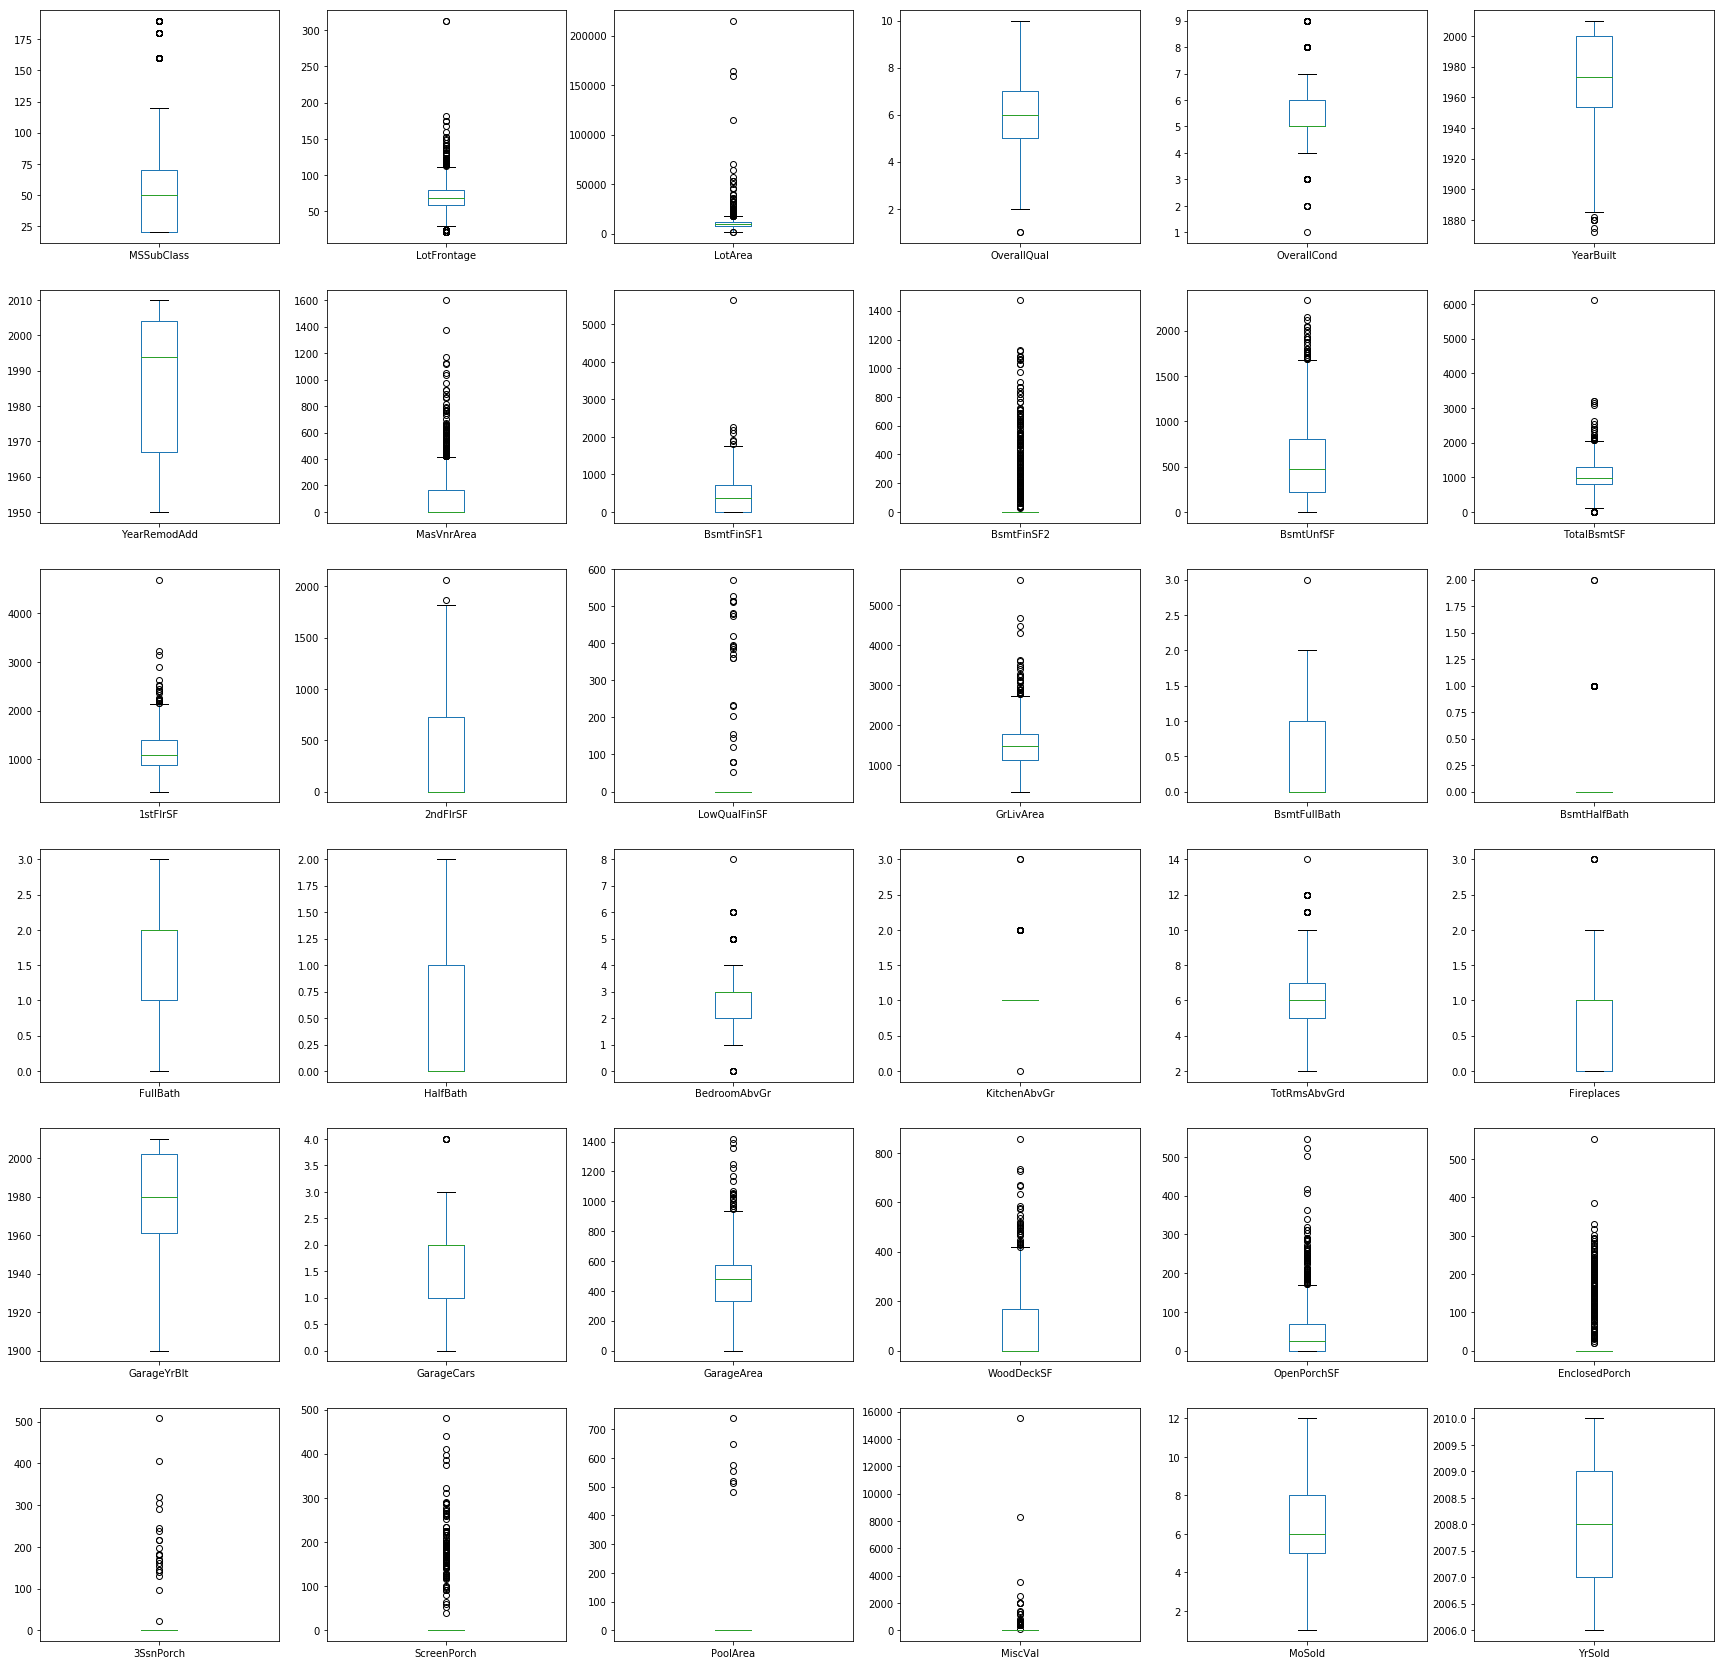

In [19]:
plotfeats(df_train,feats_numeric,kind='box',cols=6)

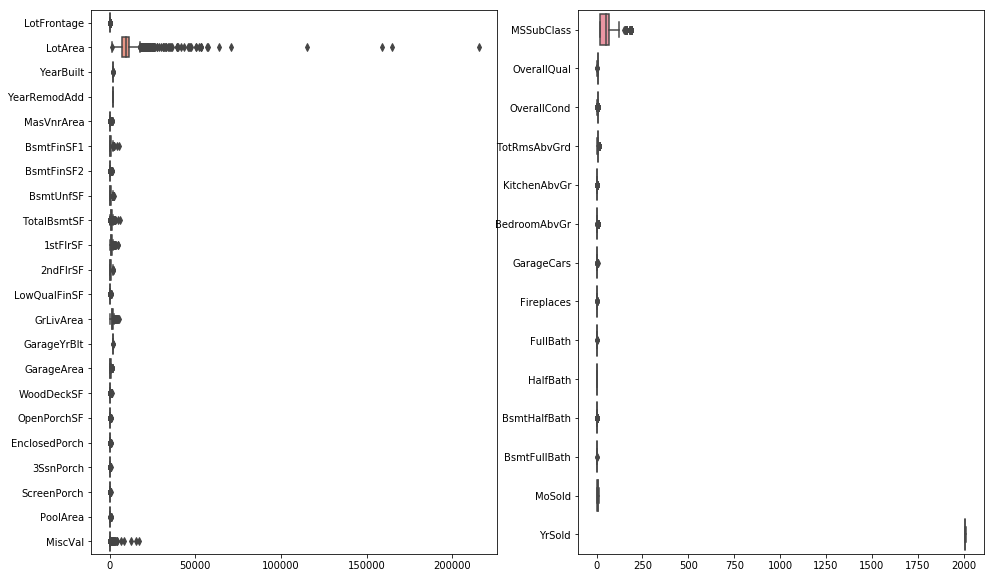

In [20]:
# 由于没有标准化，比例尺差异巨大，此处的绘图不具参考意义，待标准化后的数据才可以

plt.figure(figsize=(16,10))

plt.subplot(121)
sns.boxplot(data=df_allX[feats_continu],orient="h")

plt.subplot(122)
sns.boxplot(data=df_allX[feats_discrete],orient="h")

### SalePrice 的分散度

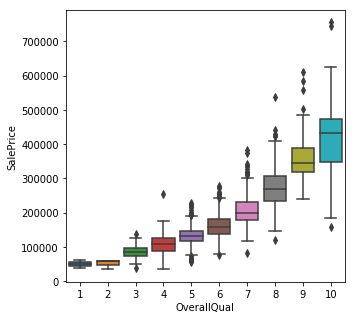

In [21]:
plotfeats(df_train, ['OverallQual'], kind='boxp', cols=6)

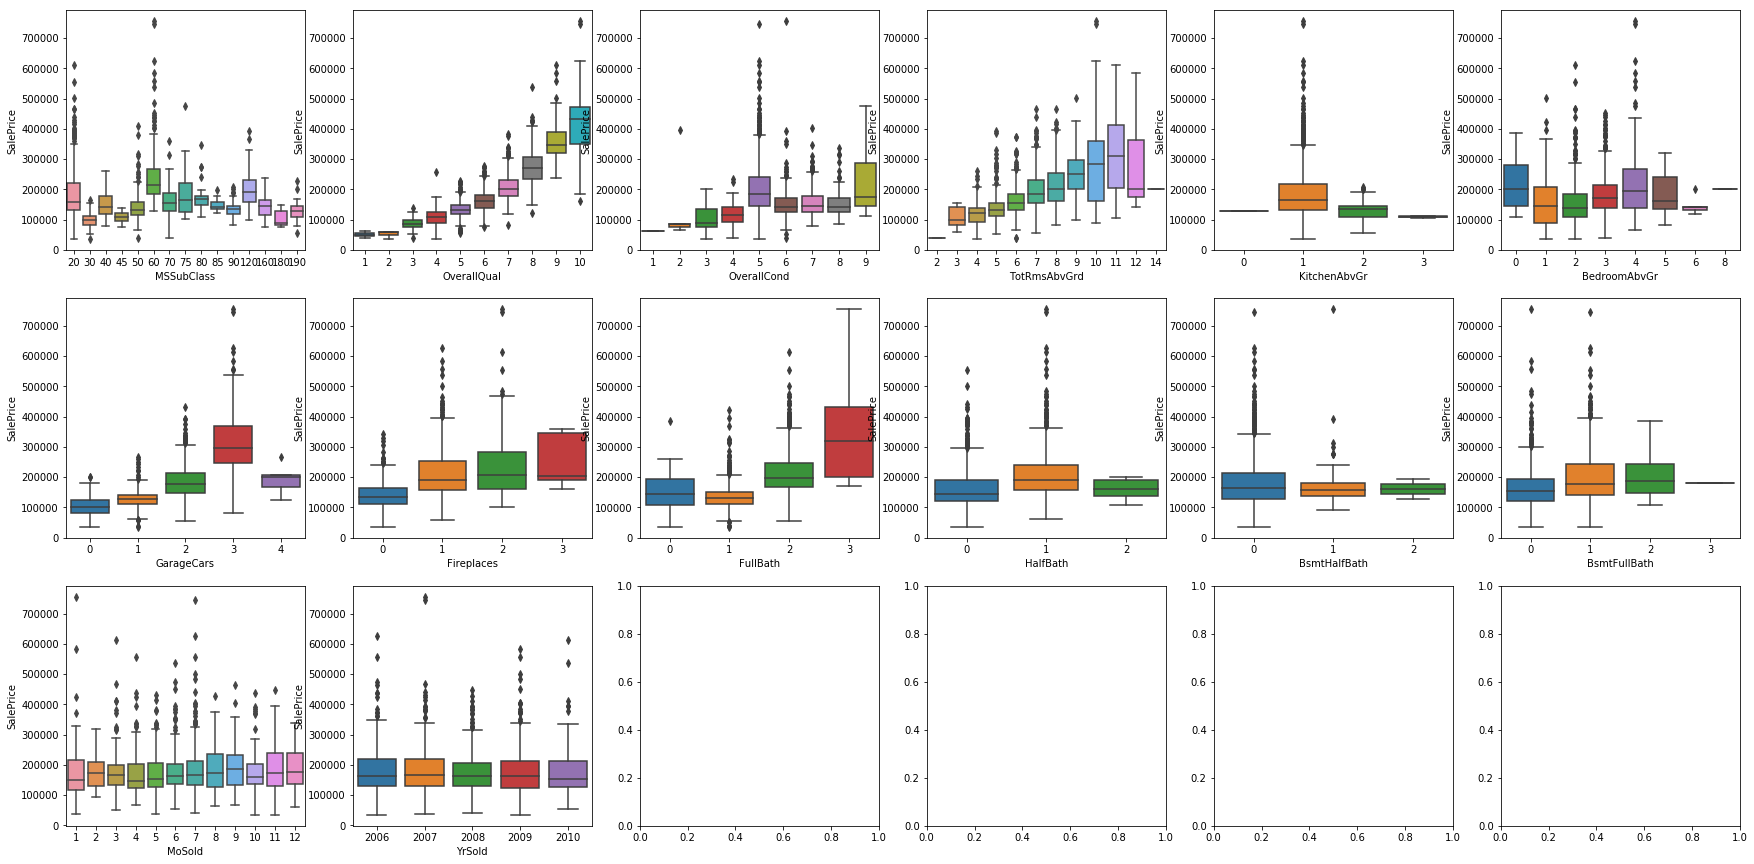

In [22]:
plotfeats(df_train, feats_numeric_discrete, kind='boxp', cols=6)

分析上图：

箱线图我基本看做散点图的加强版，最上面的散点图可以看出基本趋势，但箱线图可以一眼看出：均值、主范围之内值的趋势，可以看出异常值的多少。

有个有趣的现象：几乎所有异常值都是向上异常，即超出上界（上面的那根横线），说明了所有不在随大流的售价都是高价，没有地板价、吐血价、大甩卖价的大量出现，博弈中明显卖方占优。

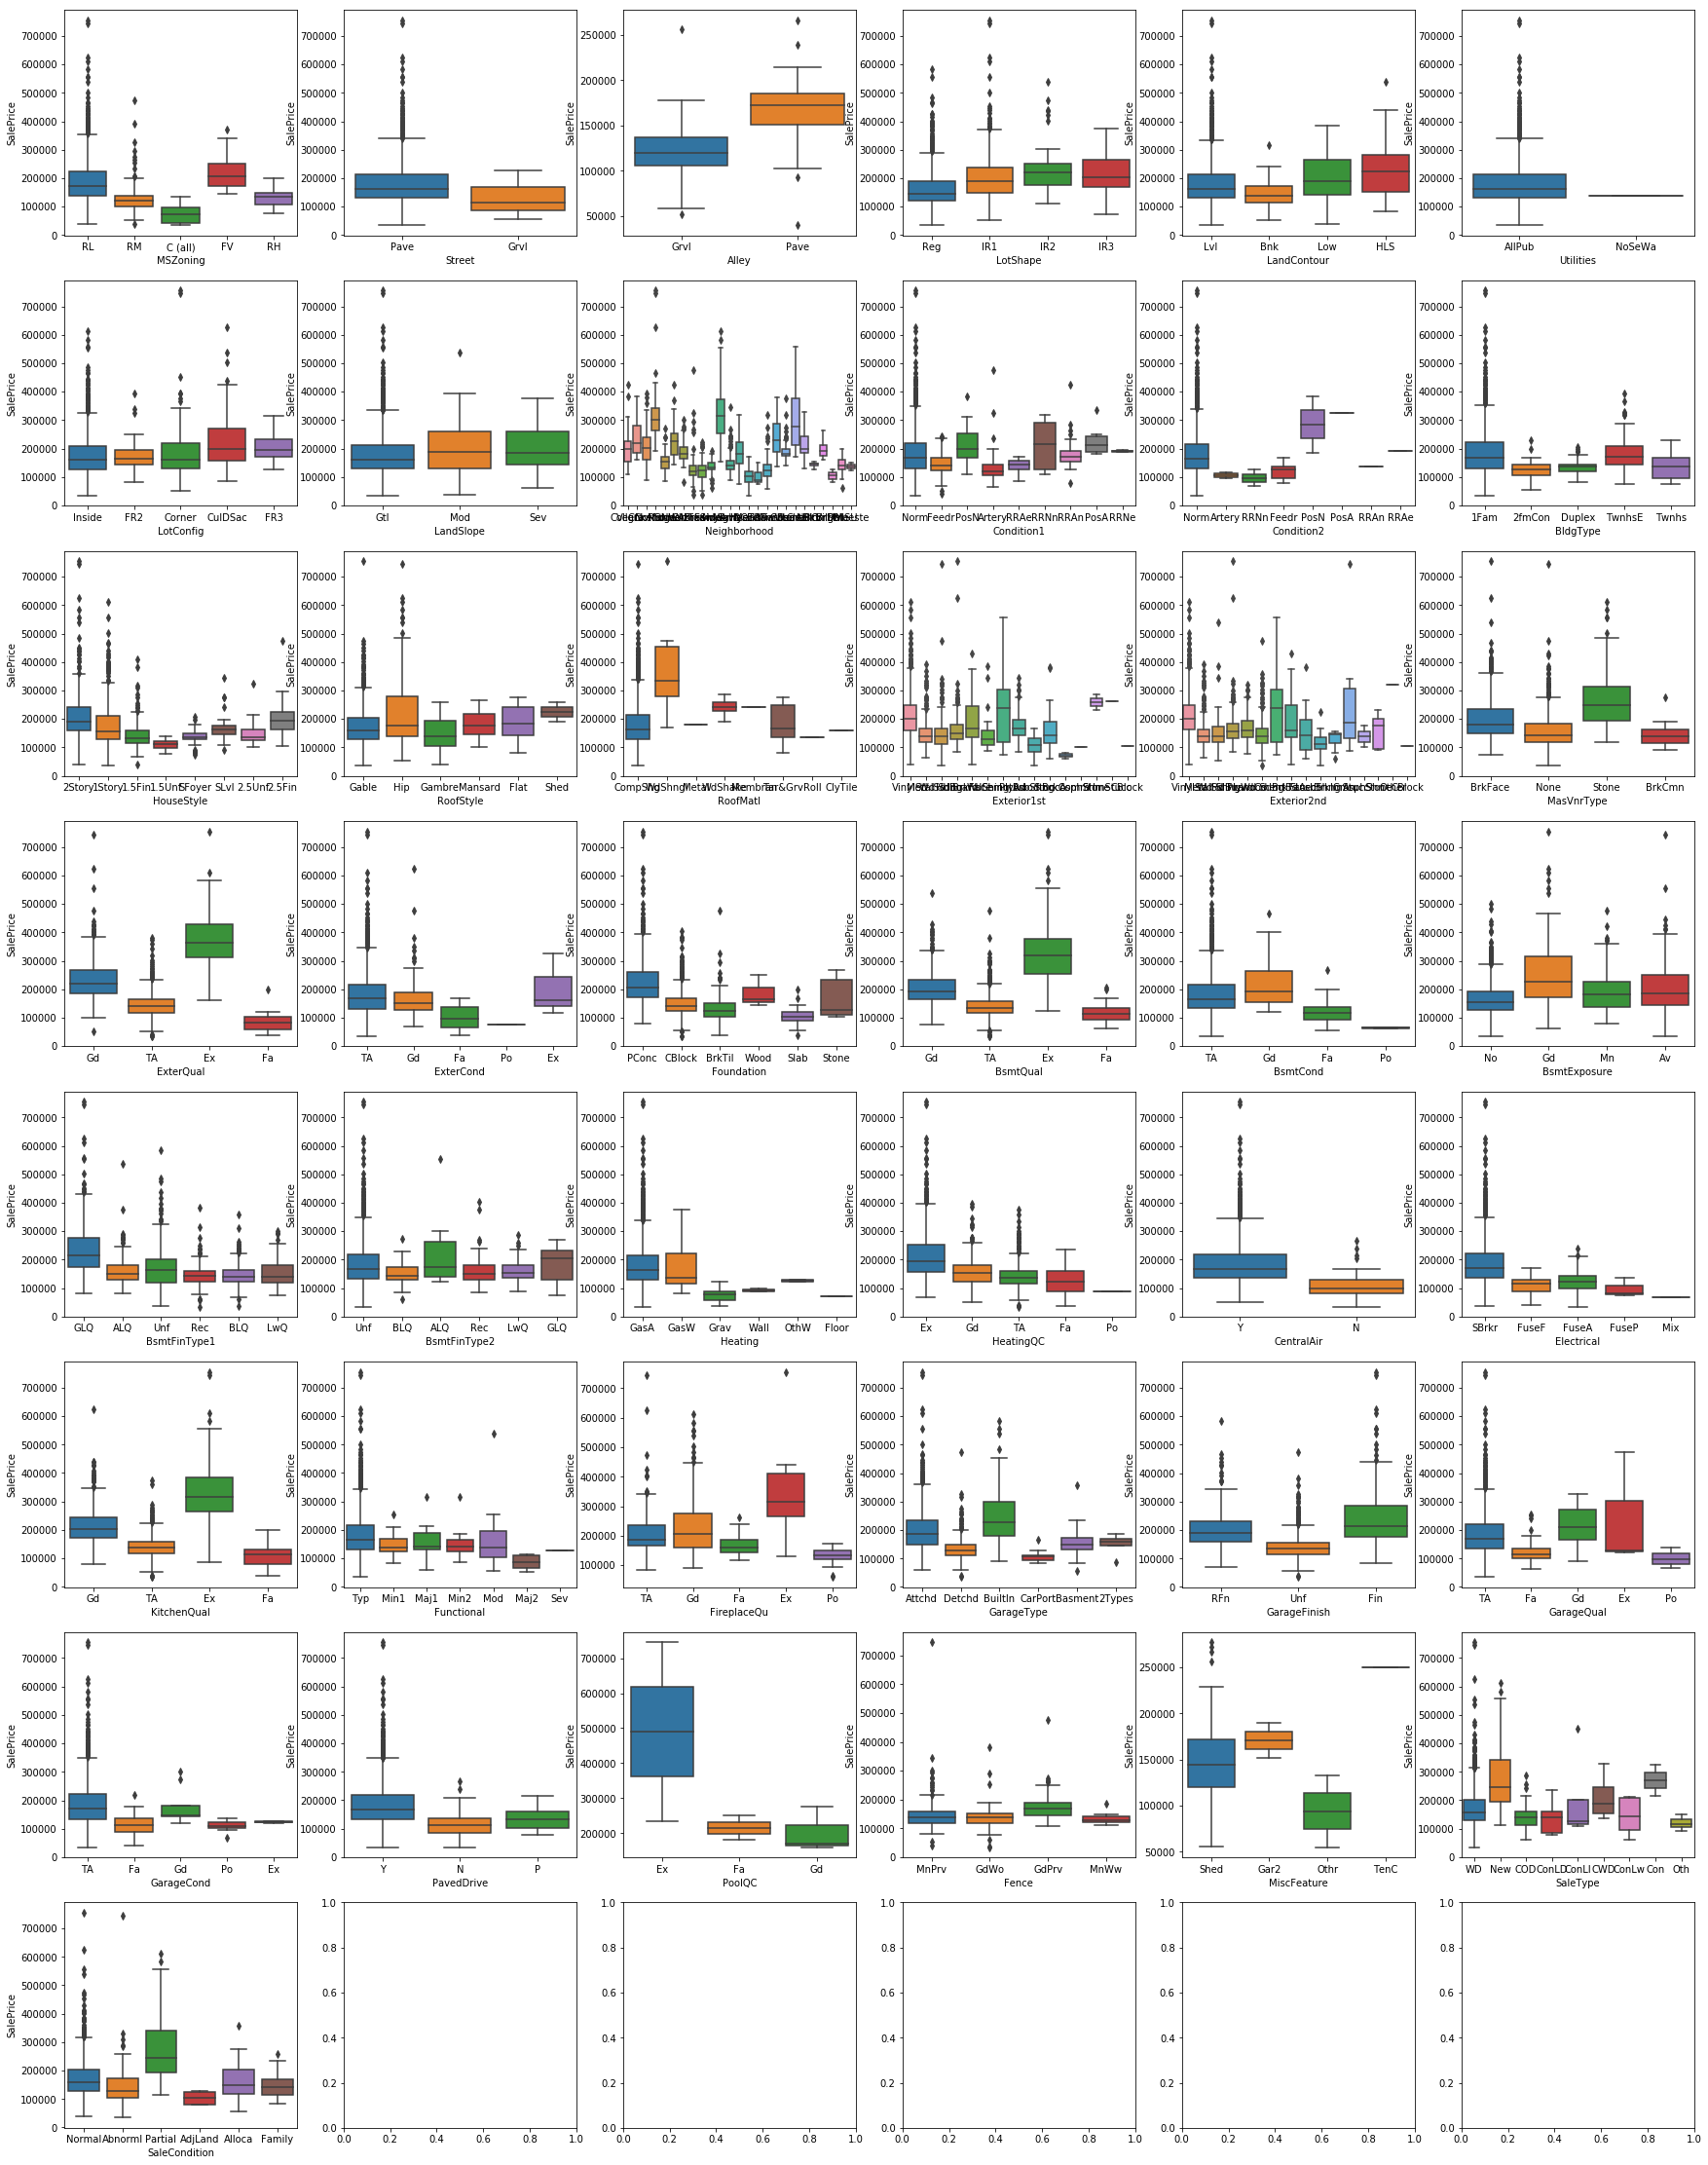

In [23]:
plotfeats(df_train, feats_object, kind='boxp', cols=6)

## 方差齐次检验

Homoscedasticity，方差齐性，也就是方差相等

常用方法有：

* Hartley检验
* Bartlett检验
* 修正的Bartlett检验

[如何理解线性回归中的方差齐性](https://www.sohu.com/a/197715883_655370)

## 方差分析(bar)

Analysis of Variance，简称ANOVA,又称“变异数分析”或“F检验”.

* 分类
    * 按自变量（影响分析指标的因素）的个数
        * 单因素方差分析
        * 双因素方差分析
        * 三因素方差分析
    * 按因变量（分析指标、又称F统计量）的个数
        * 一元方差分析（ANOVA - Analysis Of Variance）
        * 协方差分析（ANCOVA - Analysis of Covariance）
        * 多元方差分析（MANOVA - Multivariate Analysis Of Variance）
    * 举例
        * ANOVA：
            * 单因：
                * 不同施肥量是否给农作物产量带来显著影响
                * 地区差异是否影响妇女的生育率
                * 学历对工资收入的影响
                * 房子的户型是否对房价有影响 —— 本例
                    * 单因：指房型
                    * 多水平：指房型有：1室2厅、2室4厅2卫……
                    * 一元：值房价
                    * 最初我们拿到的是房型-房价的对应数据，但需要我们根据根据多水平将因变量（房价）分解为多组数据，然后对这多组的房价进行方差分析，最终获得“组内”、“组间”……的特征
                * 房子是否有砌墙是否对房价有影响 —— 本领
            * 多因A：
                * 不同品种、不同施肥量对农作物产量的影响
* 指标
    * SS（Sum of Squares，平方和，=∑(Yi-Ymean)^2 ）离散程度
        * SSE: 组内样本与平均值的离散程度
        * SSF：各组平均值与总平均值的离散程度
        * SST = SSE + SSF
    * df：自由度
        * dfE：组内 n - m  // m组，每组n个样本
        * dfF：组间 m - 1
        * dfT：合计 n - 1
    * Mean Square：均方差 = 变动/自由度
        * 组内均方差: MSE = SSE/dfE = SSE/(n-m)
        * 组间均方差：MSF = SSF/dfF = SSF/(m-1)
        * 总体均方差：MST = SST/dfT = SST/(n-1)
    * F：= MSF/MSE，组间差异显著性水平
        * 越大，说明组间变异相对组内变异越大
        * 到底多大才有意义，看 P 值
    * P(Sig) = F/F表查询值：显著性水平、检验水平
        * **P < 0.05 :（组间差异）显著**
        * **P = 0 : 组间没有可比性**
* 实现:
    * Matlab：`anova1(x)` 
    * Scipy： `f,p = scipy.stats.f_oneway(sample1, sample2, ...)`

**========= Test =========**

In [24]:
a = np.random.random(size=(1000,))
b = np.random.random(size=1000,)
f,p = stats.f_oneway(a, b)
print(f,p)

0.24196187006717482 0.6228467628947079


In [25]:
a = np.random.randn(1000,)
b = np.random.randn(1000,)
f,p = stats.f_oneway(a, b)
print(f,p)

0.05266302509664671 0.8185160426809268


In [26]:
a = np.random.randint(1,10,size=1000,)
b = np.random.randint(1,10,size=1000,)
f,p = stats.f_oneway(a, b)
print(f,p)

0.40495821499452733 0.5246125651911715


In [27]:
a = np.random.randint(1,10,size=1000,)
b = np.random.randint(5,15,size=1000,)
f,p = stats.f_oneway(a, b)
print(f,p)

1235.5351012225042 3.864871225729486e-211


In [28]:
a = np.random.binomial(5,0.2,size=1000)
b = np.random.randn(1000,)
f,p = stats.f_oneway(a, b)
print(f,p)

628.4790214889575 7.975684656958985e-121


**========= Test Over =========**

### scipy.stats.f_oneway()

In [29]:
# stats.f_oneway() 的入参是分好组的多个array 
# 本例将2列数据(自变量X、因变量Y)的dataframe转换为分组数据
def anovaXY(data):
    samples = []
    X = data.columns[0]
    Y = data.columns[1]
    for level in data[X].unique():
        if (type(level) == float): # np.NaN 的特殊处理
            s = data[data[X].isnull()][Y].values
        else:
            s = data[data[X] == level][Y].values
        samples.append(s)
    f,p = stats.f_oneway(*samples) # 也能用指针？
    return (f,p)

**使用方差分析某些feature和SalePrice之间关联的显著程度如何：**

In [30]:
df = pd.DataFrame(columns=('feature','f','p','logp'))
df['feature'] = feats_discrete
for fe in feats_discrete:
    data = pd.concat([df_train[fe],df_train['SalePrice']],axis=1)
    f,p = anovaXY(data)
    df.loc[df[df.feature==fe].index,'f'] = f
    df.loc[df[df.feature==fe].index,'p'] = p
    df.loc[df[df.feature==fe].index,'logp'] = 1000 if (p==0) else np.log(1./p)

# OverallQual 的 p=0，说明房价和整体评价紧密相关

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56]), <a list of 57 Text xticklabel objects>)

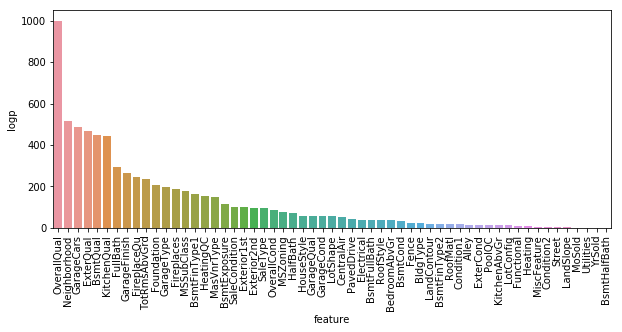

In [31]:
plt.figure(figsize=(10,4))
sns.barplot(data=df.sort_values('p'), x='feature', y='logp')
plt.xticks(rotation=90)

### pandas.Series.corr()

In [32]:
def spearman(frame, features):
    '''
    采用“斯皮尔曼等级相关”来计算变量与房价的相关性(可查阅百科)
    '''
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['corr'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features] # 此处用的是 Series.corr() 
    spr = spr.sort_values('corr')
    plt.figure(figsize=(6, 0.2*len(features)))
    sns.barplot(data=spr, y='feature', x='corr', orient='h')    
    plt.show()

/home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


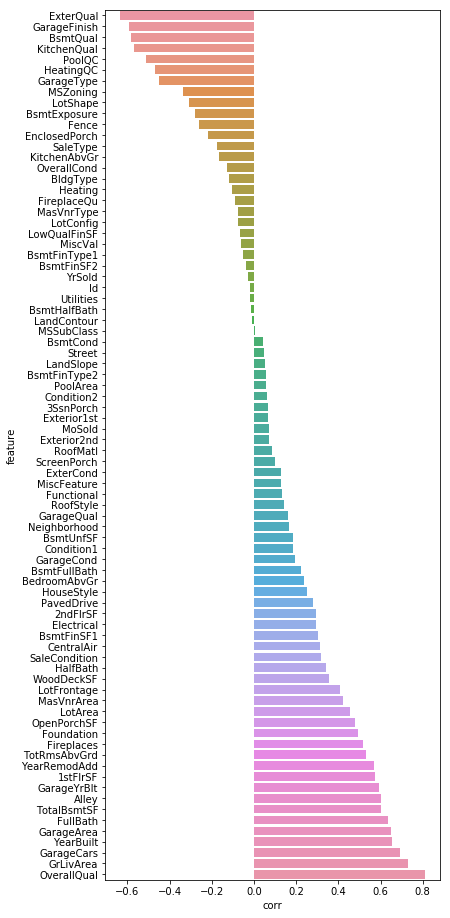

In [33]:
spearman(df_train, np.delete(df_train.columns.values,-1))

**观察和分析**

* GarageCars 和 GarageArea：因为 GarageCars 与 SalePrice 相关系数更大，可以保留这个，删除 GarageArea
* 同理，TotalBsmtSF 删除，保留 1stFlrSF

## 协方差分析(-1~+1)

**上面的方差分析，其实不过是下面协方差结果中的一列而已。**

使用 DataFrame.corr(method='pearson', min_periods=1) 函数计算协方差，此函数返回值也是个 DataFrame，非常适合 heatmap 来绘图展示。

method 有3种：  
* pearson : standard correlation coefficient —— 标准相关系数
* kendall : Kendall Tau correlation coefficient —— KT相关系统
* spearman : Spearman rank correlation —— 斯皮尔曼相关系数

返回值： 计算了任意两个feature之间的关联程度

* 当 cov(X, Y)>0时，表明 X与Y 正相关；
* 当 cov(X, Y)<0时，表明X与Y负相关；
* 当 cov(X, Y)=0时，表明X与Y不相关。

In [34]:
corr_pearson = df_train.corr(method='pearson')
corr_spearman = df_train.corr(method='spearman')

In [35]:
# corrmat 是 38*38的矩阵：所以只是 numeric 的 feature 才会参与计算
corr_pearson.shape

(38, 38)

In [36]:
corr_spearman.shape

(38, 38)

### 协方差热图(heatmap)

* heatmap: 
    * matplotlib 画heatmap比较麻烦，没有简单接口
    * sns.heatmap() 是个不错的选择
* 颜色越浅，协方差越大，两个变量关联性越大；
* 颜色越深，逆相关;

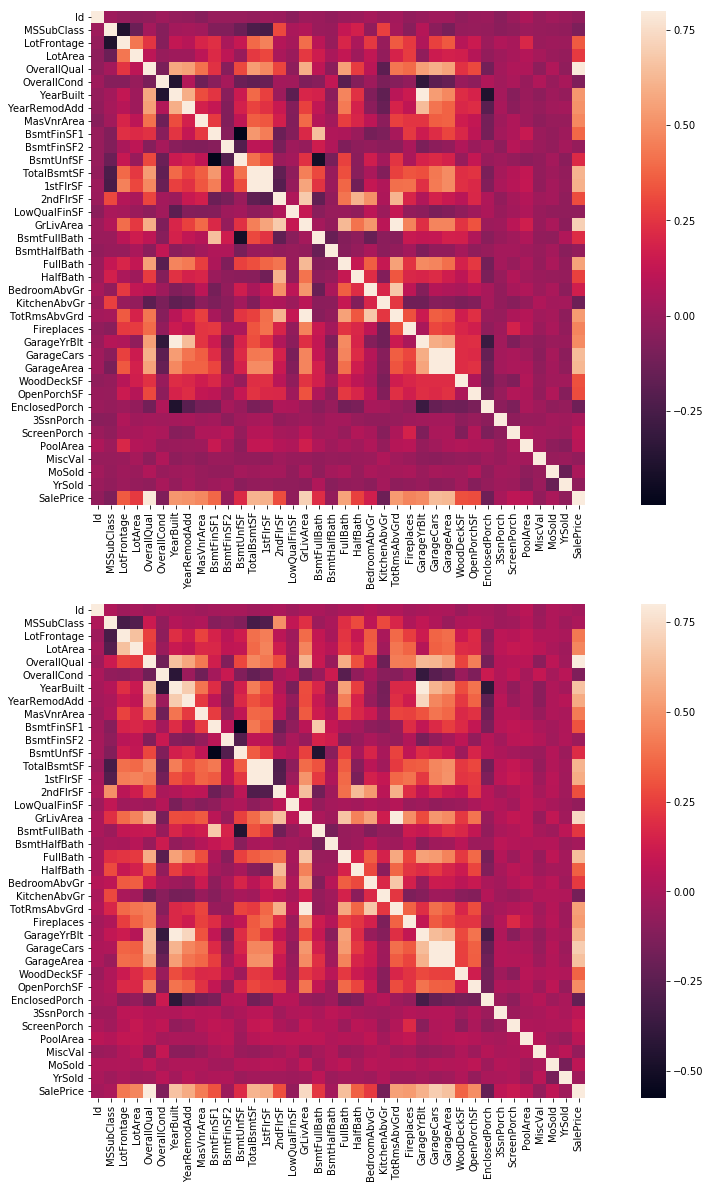

In [37]:
# 如果不设置figsize，会出现部分数据不显示的情况
# 就是说要手工计算充分的空间给sns.heatmap() —— 这都是啥bug啊
plt.figure(figsize=(20, 20))
plt.subplot(211)
sns.heatmap(corr_pearson, vmax=.8, square=True);
plt.subplot(212)
sns.heatmap(corr_spearman, vmax=.8, square=True);

分析上图：  

* 中间2个比较大的白色块：
    * TotalBsmtSF--1stFlrSF：地下室面积和1楼面积正相关 —— 好像很废话哦，呵呵
    * GarageCars--GarageArea：车库面积和停车容量正相关 —— 也很废话
    * 上面4个在建模时可以去除2个，另外2个是无效feature
    * 这叫：**多重共线性**


### 协方最大关联图(pairplot)

In [40]:
feats_d = corr_pearson.nlargest(8,'SalePrice').index
feats_d

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath'],
      dtype='object')

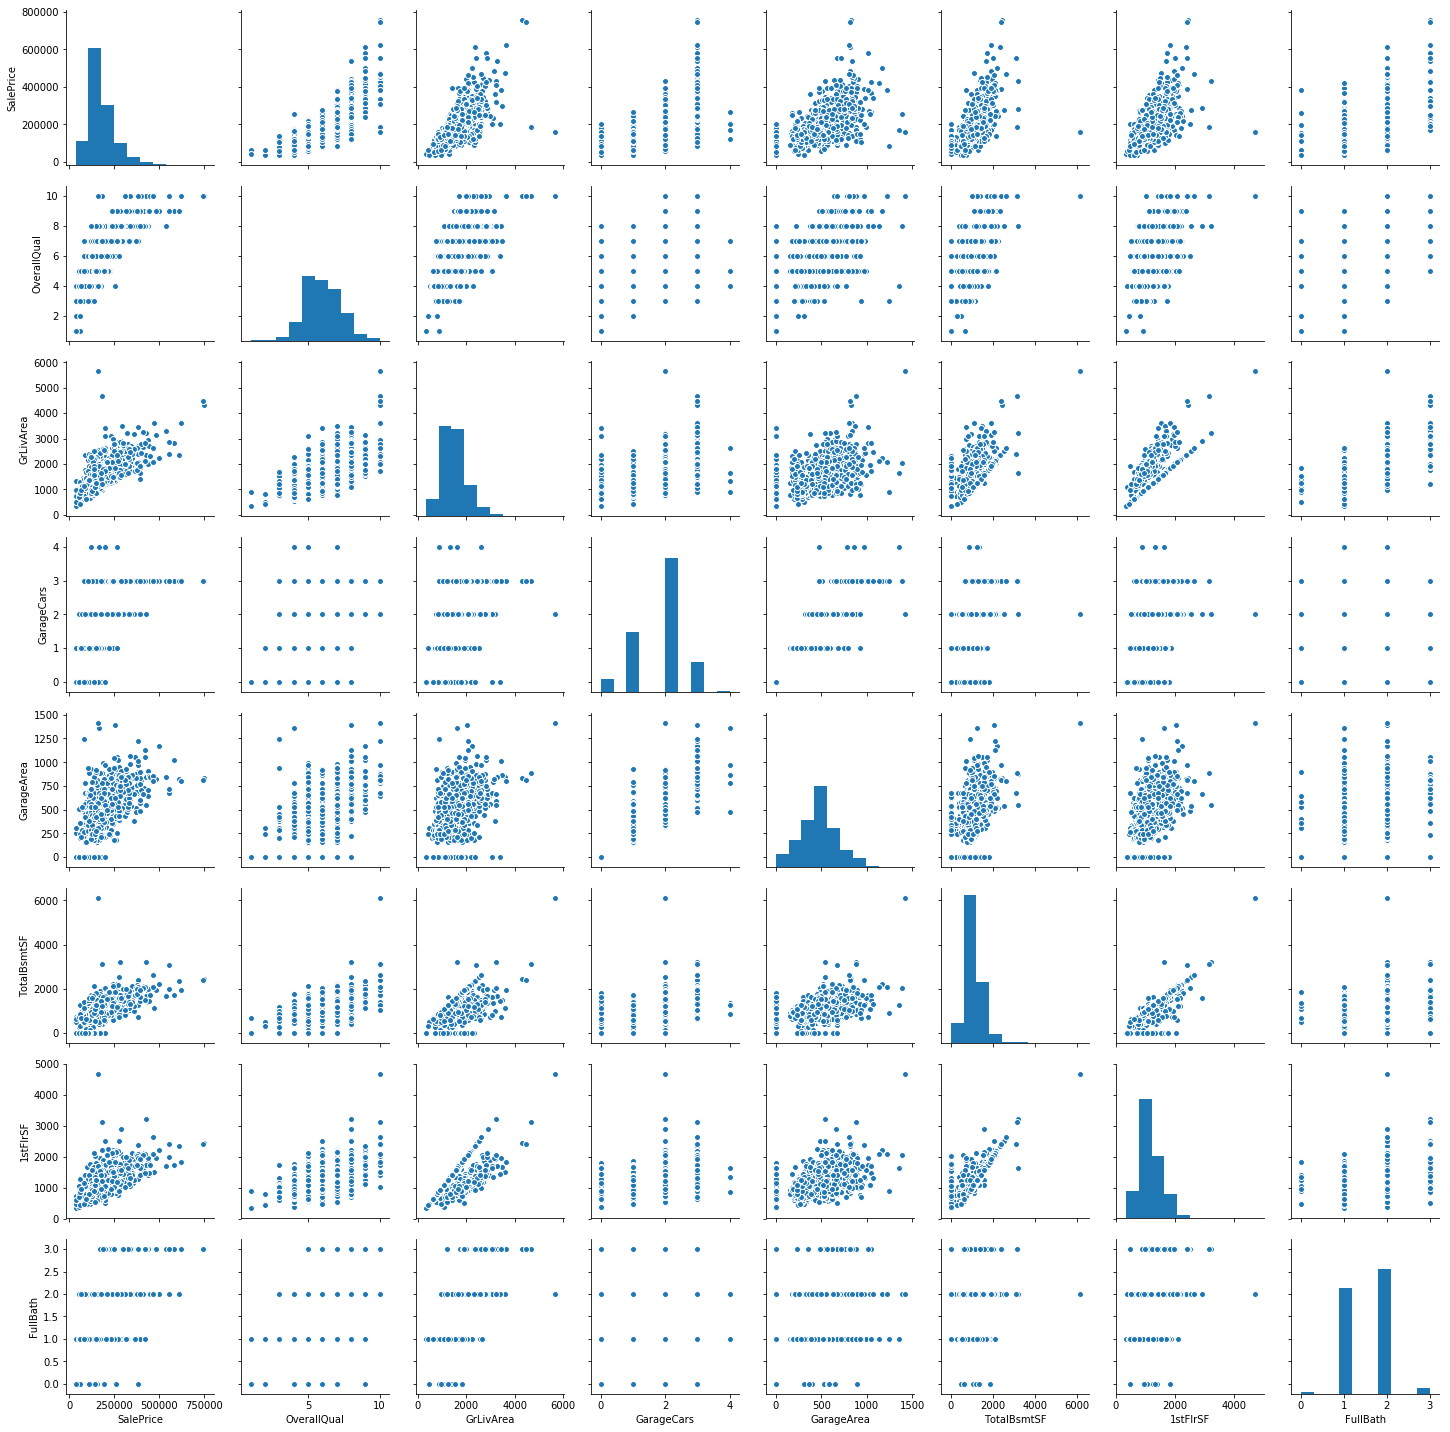

In [41]:
sns.pairplot(df_train[feats_d],size=2.5)

图画的越来越花哨，我已无力分析，还是开始数据处理吧。

# **数据处理**

## 无效数据处理

### 无效特征处理

根据逻辑和理论，删除一些违反原则的特征：

* YrSold、MoSold：我觉得和预测房价不相关
* OverallQual: 太人为化了，完全不理性
* YearBuild: 房地产的口头禅：地段、地段、地段，房龄几乎无关
* TotalBsmtSF：地下室面积
* GrLivArea：地面以上面积

In [42]:
feats_del = ['YrSold','MoSold']

In [43]:
df_allX.shape

(2919, 79)

In [44]:
df_allX.drop(feats_del, axis=1, inplace=True)  # 快意泯恩仇 ：）

In [45]:
for f in feats_del:
    feats_numeric  = np.delete(feats_numeric,  np.where(feats_numeric  == f))
    feats_object   = np.delete(feats_object,   np.where(feats_object   == f))
    feats_continu  = np.delete(feats_continu,  np.where(feats_continu  == f))
    feats_discrete = np.delete(feats_discrete, np.where(feats_discrete == f))

In [46]:
df_allX.shape

(2919, 77)

### 离群点处理

离群点不同于分散度，离群点指偏离趋势的点，比如某特征和房价是正相关的，在趋势轴上即时很分散，但是不可以删除的，而不在趋势轴上的“离群点”是需要删除的。

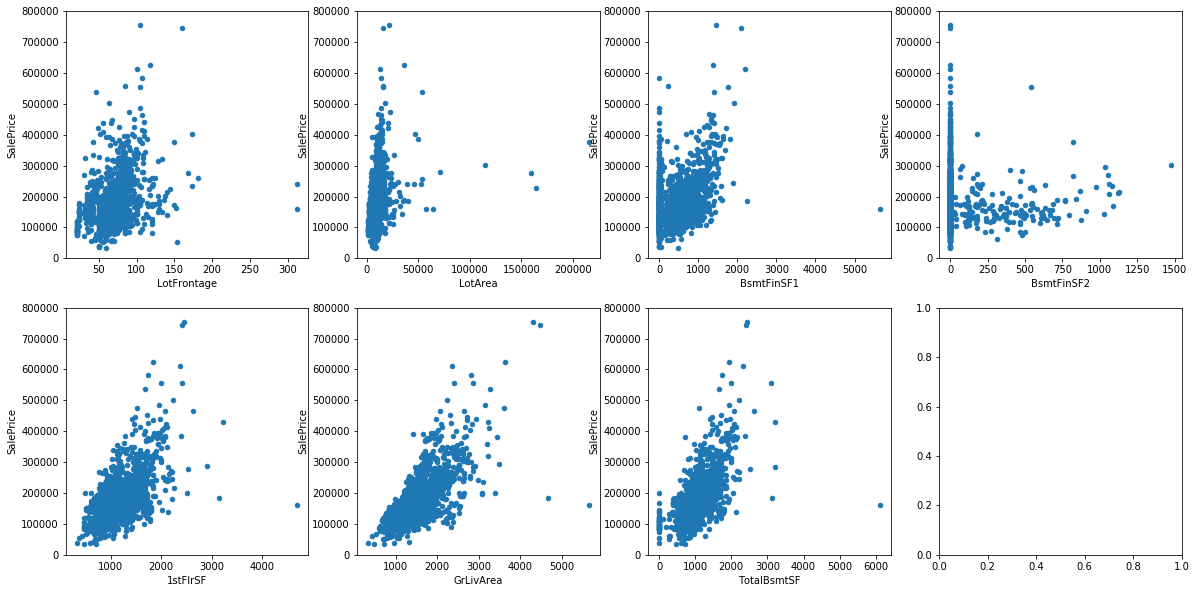

In [47]:
# 经过前面偏离度分析，可以观察得出下面几个feature存在离群点
feats_away = ['LotFrontage','LotArea','BsmtFinSF1','BsmtFinSF2','1stFlrSF','GrLivArea','TotalBsmtSF']
plotfeats(df_train,feats_away,kind='scatter')

**手工删除离群点** —— 这是个体力活啊！  
并且离群点是以 SalePrice 为参照的，而 df_allX 中没有 SalePrice，只有 df_train 中有。  
df_allX 前面已经重新排序了Id，但前半部分的的 Id 应该是和 df_train 相同的，可以使用。

In [48]:
ids = []

In [49]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2][['Id','GrLivArea','SalePrice']]
# 1299 是 df_train 中的 Id 列， 1298 对应 df_allX 中的 index

,Id,GrLivArea,SalePrice
1298,1299,5642,160000
523,524,4676,184750


In [50]:
ids.append(1299)
ids.append(524)

In [51]:
df_train.sort_values(by = 'TotalBsmtSF', ascending = False)[:2][['Id','TotalBsmtSF','SalePrice']]
# 1299 又出现了，看来提供这个数据的同学是不是恶作剧啊？

,Id,TotalBsmtSF,SalePrice
1298,1299,6110,160000
332,333,3206,284000


In [52]:
df_train.sort_values(by = '1stFlrSF', ascending = False)[:2][['Id','1stFlrSF','SalePrice']]

,Id,1stFlrSF,SalePrice
1298,1299,4692,160000
496,497,3228,430000


In [53]:
df_train.sort_values(by = 'BsmtFinSF1', ascending = False)[:2][['Id','BsmtFinSF1','SalePrice']]
# 全部指向 1299，此行数据必须除之

,Id,BsmtFinSF1,SalePrice
1298,1299,5644,160000
523,524,2260,184750


In [54]:
df_train.sort_values(by = 'LotArea', ascending = False)[:3][['Id','LotArea','SalePrice']]

,Id,LotArea,SalePrice
313,314,215245,375000
335,336,164660,228950
249,250,159000,277000


In [55]:
ids.append(314)
ids.append(335)
ids.append(250)

In [56]:
df_train.sort_values(by = 'LotFrontage', ascending = False)[:3][['Id','LotFrontage','SalePrice']]

,Id,LotFrontage,SalePrice
1298,1299,313.0,160000
934,935,313.0,242000
1127,1128,182.0,259000


In [57]:
ids.append(1299)
ids.append(935)

In [58]:
np.unique(ids)

array([ 250,  314,  335,  524,  935, 1299])

In [59]:
print(df_train.shape,df_test.shape,df_allX.shape)

(1460, 81) (1459, 80) (2919, 77)


In [60]:
for id in np.unique(ids):
    df_train = df_train.drop(df_train[df_train.Id==id].index)
    df_allX = df_allX.drop(df_allX[df_allX.index==(id-1)].index)

In [61]:
print(df_train.shape,df_test.shape,df_allX.shape)

(1454, 81) (1459, 80) (2913, 77)


## 缺失值处理

* **缺失值不等于NA**
    - 字符型特征中的 'NA' 分2类：
        1. NA 代表某个含义，是离散量/类型量的一个有意义的值，需要请参考说明文件
        2. NA 代表缺失
    - 数值量特征中的 np.NaN 一般都是缺失值了
* 缺失比例太大，或特征对任务有没有用 —— 直接删除
* 缺失比例不大，需要补全
    - 数值型特征：用min,max,mean,median或mod补全
    - 字符型特别：——暂不处理

### NaN和NA的处理函数

In [62]:
# Python 中 NaN 的类型：
print(type(None),type(np.NaN))

<class 'NoneType'> <class 'float'>


先来实现几个函数，以便后面处理 np.NaN 和 'NA'

In [63]:
def NaNRatio(frame,feats):    
    """
    查找并统计 numpy.NaN 的值, feats 可以是数值型 or 字符型特征
    """
    na_count = frame[feats].isnull().sum().sort_values(ascending=False)
    na_rate = na_count / len(frame)
    na_data = pd.concat([na_count,na_rate],axis=1,keys=['count','ratio'])
    return na_data[na_data['count']>0]

In [64]:
def NARatio(frame,feats):
    """
    查找并统计字符串 NA 的值
    """
    nadict={}
    for c in feats:        
        # 方法1：
        # frame[f][frame[f]=='NA'] —— 问题是这种方法只能比较 object 列，numeric列会报错        
        # 方法2：
        for r in frame.index:
            if 'NA'==frame.loc[r,c]:
                if 0==nadict.get(c,0):
                    nadict[c]=[]
                nadict[c].append(r)
    return nadict

In [68]:
def transNaNtoNumber(frame, column, method, val=0):
    """
    将 numpy.NaN 转为指定的数字
    """
    if method == 'mean':
        frame[column] = frame[column].fillna(round(frame[column].mean()))
    elif method == 'min':
        frame[column] = frame[column].fillna(round(frame[column].min()))
    elif method == 'max':
        frame[column] = frame[column].fillna(round(frame[column].max()))
    elif method == 'special':
        frame[column] = frame[column].fillna(val).round()
    else:
        return
    return frame

In [69]:
def transNaNtoNA(frame, feature):
    """
    将 numpy.NaN 转为字符串 NA
    """
    # frame[feature][df[feature].isnull()] = 'NA' # 这么写有warnning
    frame.loc[frame[feature].isnull(),feature] = 'NA'

In [70]:
def transNAtoNumber(frame,feat,val=0):
    """
    将字符串 NA 替换为指定数值（默认0）
    """
    for r in frame[frame[feat]=='NA'].index:
        frame.loc[r,feat] = val
    return frame

### 数值量:min,max,mean

In [71]:
# 查看数值型特征的 NA 值的数量和比例
pd.concat([NaNRatio(df_train,feats_numeric),NaNRatio(df_test,feats_numeric)],axis=1)

,count,ratio,count,ratio
BsmtFinSF1,NaN,NaN,1,0.000685
BsmtFinSF2,NaN,NaN,1,0.000685
BsmtFullBath,NaN,NaN,2,0.001371
BsmtHalfBath,NaN,NaN,2,0.001371
BsmtUnfSF,NaN,NaN,1,0.000685
GarageArea,NaN,NaN,1,0.000685
GarageCars,NaN,NaN,1,0.000685
GarageYrBlt,81.0,0.055708,78,0.053461
LotFrontage,258.0,0.177442,227,0.155586
MasVnrArea,8.0,0.005502,15,0.010281


下面又是个体力活，可以像我这样逐个特征分析，然后使用不同的方式填补缺失值，也可以一刀切取个mean，不见得不好，我只是强迫症，想看看有啥影响。

In [72]:
#LotFrontage：到街道的距离：取平均值
df_allX = transNaNtoNumber(df_allX,'LotFrontage','mean') 

#GarageYrBlt：车库的建造年份：因为没有车库才没有年份，所以不能取平均值，暂取最小值
df_allX = transNaNtoNumber(df_allX,'GarageYrBlt','min')

#MasVnrArea：砌墙面的面积，因为没有砌墙才导致为0，取最小值替代
df_allX = transNaNtoNumber(df_allX,'MasVnrArea','special',0)

#其他：比例较小，统一用mean替代
df_allX = df_allX.fillna(df_allX.mean())

In [73]:
# df_allX 中的数值型特征中已没有 np.NaN
pd.concat([NaNRatio(df_allX,feats_numeric)],axis=1)

,count,ratio


### 字符量 -- 仅做类型转换

将其从float的类型转变为char的"NA"

In [74]:
pd.concat([NaNRatio(df_train,feats_object),NaNRatio(df_test,feats_object)],axis=1)

,count,ratio,count,ratio
Alley,1363.0,0.937414,1352.0,0.926662
BsmtCond,37.0,0.025447,45.0,0.030843
BsmtExposure,38.0,0.026135,44.0,0.030158
BsmtFinType1,37.0,0.025447,42.0,0.028787
BsmtFinType2,38.0,0.026135,42.0,0.028787
BsmtQual,37.0,0.025447,44.0,0.030158
Electrical,1.0,0.000688,NaN,NaN
Exterior1st,NaN,NaN,1.0,0.000685
Exterior2nd,NaN,NaN,1.0,0.000685
Fence,1173.0,0.806740,1169.0,0.801234


In [75]:
for c in feats_object:
    transNaNtoNA(df_allX,c)

In [76]:
# df_allX 中的字符型特征中已没有 np.NaN
NaNRatio(df_allX,feats_object)

,count,ratio


## 标准化(Normalization)处理

标准化 (normalization)  
将实际的值区间转换为标准的值区间(通常为 -1 到 +1 或 0 到 1)的过程。例如,假设某个特征的自然区间是 800 到 6000。通过减法和除
法运算,您可以将这些值标准化为位于 -1 到 +1 区间内。  
—— 机器学习术语-中文版(Machine Learning Glossary_Google Developers)

常用标准化方法：

1. z-score
$$x_i = \frac{x_i - \mathbb{E} x_i}{\text{std}(x_i)}。$$
2. Min-Max Scaling
$$x_i = \frac{x_i - min}{max - min}$$
3. Decimal scaling小数定标标准化

In [77]:
df_allX[feats_numeric] = df_allX[feats_numeric].apply(lambda x:(x-x.mean())/(x.std()))

标准化后的分散度

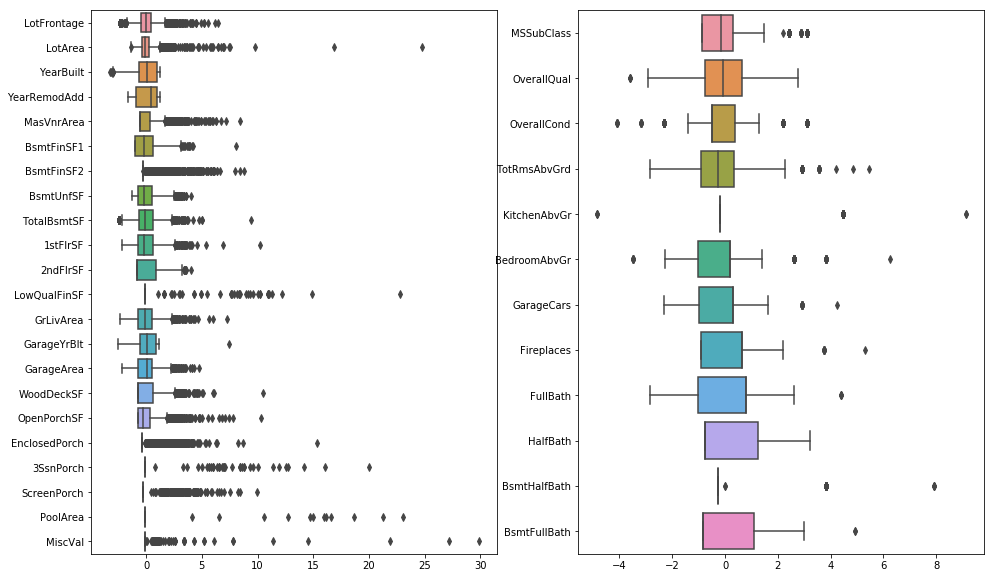

In [78]:
plt.figure(figsize=(16,10))

plt.subplot(121)
sns.boxplot(data=df_allX[feats_continu],orient="h")

plt.subplot(122)
sns.boxplot(data=df_allX[feats_discrete],orient="h")

## 离散量编码

* **离散/类型量都可以进行重新编码（encoding）：**
    * **字符型-离散量的编码：即字符量的数值化。**
    * **数值型-离散量的编码：本例需求不强烈**，因为数据提供者已经做了很好的排序，如OverallQual，10～1分别代表从VeryExcellent～VeryPoor

离散量编码的常用方法有：

1. One-Hot Encoding: 将离散量变为多个特征 —— 因为只考虑特征本身，so，可以用 df_allX 来计算
2. 分组-均值-排序法：对特征的不同取值分组，并计算每组y的均值，然后排序，最后分别将分组数值化为1,2,3... 

### One-Hot Encoding

又称：独热编码（这中文名也太low了），本质是按位编码，即使用1bit表示一个状态。

目的：

* 解决了分类器不好处理属性数据的问题，属性通常为序列值，而不是连续值，序列值没有连续值的大小、优劣……之分
* 将序列型的属性对应到欧式空间
* 在一定程度上也起到了扩充特征的作用

实现：

1. 
```
from sklearn import preprocessing
preprocessing.OneHotEncoder(sparse=False).fit_transform()
```
2. 
```
pandas.get_dummies() //dummy variables(虚拟变量、哑变量、离散特征编码)
```

In [79]:
df_allX.shape

(2913, 77)

In [80]:
#df_allX = pd.get_dummies(df_allX[feats_object], dummy_na=True)

In [81]:
df_allX.shape

(2913, 77)

### 分组-均值-排序数值化

* **以SalePrice为参考，将某个特征按每个离散值计算SalePrice对应的均值，排序后给出1、 2、 3……等数值**
* **因为需要SalePrice参与计算，所以需要 df_train 计算，然后应用到 df_allX 上**
* **时刻记住： np.NaN 和 'NA' 字符串的区别**
* **问题：如果某个特征在 df_train 中没有NA，仅在 df_test 中有NA，则无法处理**

#### 以SalePrice为参考的数据

In [82]:
def encode(frame, feature, targetfeature='SalePrice'):
    ordering = pd.DataFrame()
    # 找出指定特征的水平值，并做临时df的索引
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    # 按各水平分组，并求每组房价的均值
    ordering['price_mean'] = frame[[feature, targetfeature]].groupby(feature).mean()[targetfeature]
    # 排序并为order列赋值1、2、3、……
    ordering = ordering.sort_values('price_mean')
    ordering['order'] = range(1, ordering.shape[0]+1)
    ordering = ordering['order'].to_dict()
    return ordering

**需要转为字符'NA'才能做 encode()，否则在计算 groupby() 时会漏掉 NaN 型 **

测试：

In [83]:
encode(df_train,'BsmtCond') # numpy.NaN 的处理不是所希望的

{'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3, nan: 5}

In [84]:
dfc = df_train.copy()
transNaNtoNA(dfc,'BsmtCond') # 把 NaN 转为 'NA'
encode(dfc,'BsmtCond') # 字符串 NA 能够正确处理

{'Fa': 3, 'Gd': 5, 'NA': 2, 'Po': 1, 'TA': 4}

测试完毕

In [85]:
# 转前留证
df_allX.loc[20:30,'Alley'] 

20      NA
21    Grvl
22      NA
23      NA
24      NA
25      NA
26      NA
27      NA
28      NA
29      NA
30    Pave
Name: Alley, dtype: object

In [86]:
dfc = df_train.copy()

for fb in feats_object:
    print("\r\n-----\r\n",fb,end=':')
    transNaNtoNA(dfc,fb)
    for attr_v, score in encode(dfc,fb).items():
        print(attr_v,score,end='\t')
        df_allX.loc[df_allX[fb] == attr_v, fb] = score        


-----
 MSZoning:C (all) 1	RH 3	RM 2	RL 4	FV 5	
-----
 Street:Grvl 1	Pave 2	
-----
 Alley:Grvl 1	NA 3	Pave 2	
-----
 LotShape:IR3 2	IR2 4	IR1 3	Reg 1	
-----
 LandContour:HLS 4	Bnk 1	Lvl 2	Low 3	
-----
 Utilities:AllPub 2	NoSeWa 1	
-----
 LotConfig:FR3 4	Inside 1	CulDSac 5	FR2 2	Corner 3	
-----
 LandSlope:Sev 2	Gtl 1	Mod 3	
-----
 Neighborhood:Blmngtn 16	Crawfor 19	NoRidge 25	MeadowV 1	BrkSide 4	NAmes 11	OldTown 6	BrDale 3	CollgCr 17	Blueste 8	Edwards 5	Veenker 22	Somerst 20	NWAmes 14	Gilbert 15	IDOTRR 2	StoneBr 23	NridgHt 24	Sawyer 7	SWISU 9	Mitchel 12	ClearCr 18	SawyerW 13	Timber 21	NPkVill 10	
-----
 Condition1:Feedr 3	RRNe 6	PosA 9	RRAe 2	Norm 4	RRNn 7	RRAn 5	Artery 1	PosN 8	
-----
 Condition2:Feedr 3	RRAe 6	Norm 5	PosN 8	RRNn 1	RRAn 4	Artery 2	PosA 7	
-----
 BldgType:TwnhsE 4	2fmCon 1	Twnhs 3	Duplex 2	1Fam 5	
-----
 HouseStyle:1.5Unf 1	2.5Unf 4	2Story 7	SFoyer 2	2.5Fin 8	SLvl 5	1.5Fin 3	1Story 6	
-----
 RoofStyle:Shed 6	Hip 5	Gambrel 1	Mansard 3	Flat 4	Gable 2	
-----
 RoofMatl:WdSh

In [87]:
# 转后验证
df_allX.loc[20:30,'Alley'] 

20    3
21    1
22    3
23    3
24    3
25    3
26    3
27    3
28    3
29    3
30    2
Name: Alley, dtype: object

#### 没有房价可做基准的数据处理

个别特征 train 中没有 NA，test 中有 NA，需要单独处理

In [88]:
# 检查一遍是否还有 numpy.NaN
NaNRatio(df_allX,df_allX.columns.values)

,count,ratio


In [89]:
# 检查一遍是否还有 'NA'
stillNA = NARatio(df_allX,df_allX.columns.values)
stillNA

{'Exterior1st': [2151],
 'Exterior2nd': [2151],
 'Functional': [2216, 2473],
 'KitchenQual': [1555],
 'MSZoning': [1915, 2216, 2250, 2904],
 'SaleType': [2489],
 'Utilities': [1915, 1945]}

In [90]:
df_allX.loc[1914:1916,'MSZoning'] #果然有

1914     2
1915    NA
1916     4
Name: MSZoning, dtype: object

好吧，该处理他们了：

MSZoning: 区域划分：农业、工业、商业、住宅高、中、低、花园密度区  
查看了一下对应的 OverallQual（与房价方差分析最紧密关联的特征）为：  
2、 1、 5、 1 —— 各种都有  

**所以这里都取平均值吧**

In [91]:
df_allX[['MSZoning','OverallQual']][df_allX['MSZoning']=='NA']

,MSZoning,OverallQual
1915,NA,-2.902967
2216,NA,-3.613464
2250,NA,-0.771474
2904,NA,-3.613464


In [92]:
dftemp = df_allX.copy()
for sn in stillNA.keys():
    print(sn)
    dftemp  = transNAtoNumber(dftemp,sn)
    df_allX = transNAtoNumber(df_allX,sn,dftemp[sn].mean())

KitchenQual
Utilities
Exterior1st
SaleType
MSZoning
Functional
Exterior2nd


In [93]:
df_allX.loc[1914:1916,'MSZoning']

1914          2
1915    3.69173
1916          4
Name: MSZoning, dtype: object

In [94]:
NARatio(df_allX,df_allX.columns.values)

{}

# **机器学习**

参考各路英豪的经验，能做的数据分析和预处理都差不多了，该上机器学习了。

**RMSE**: Root-Mean-Squared-Error，根平均平方差，[wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation) ，这是本场比赛要求的评测标准。


In [95]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train),1,float('inf'))
    return np.sqrt( 2 * nd.sum(square_loss(nd.log(clipped_preds), nd.log(y_train))).asscalar()/num_train)

## **模型**

### MXNet

In [96]:
from mxnet import nd, autograd, gluon

把数据用 mxnet 提供的 array 初始化一下，以便用 GPU 等大招。

In [97]:
num_train = df_train.shape[0]
X_train = nd.array(df_allX[:num_train])
X_test  = nd.array(df_allX[num_train:].as_matrix())
y_train = nd.array(df_train.SalePrice.as_matrix())

In [98]:
square_loss = gluon.loss.L2Loss()

In [107]:
def get_net(units=128, dropout=0.1):
    net = gluon.nn.Sequential()
    with net.name_scope():    
        if units!=0:
            net.add(gluon.nn.Dense(units, activation='relu'))
        if dropout != 0:
            net.add(gluon.nn.Dropout(dropout))
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [108]:
def train(net, X_train, y_train, X_test, y_test, epochs, learning_rate, weight_decay):
    train_loss = []
    if X_test is not None:
        test_loss = []
    batch_size = 100
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label) 
            loss.backward()
            trainer.step(batch_size)

        # 训练用 L2Loss，画图和返回用 RMSE Loss
        train_loss.append(get_rmse_log(net, X_train, y_train))
        if X_test is not None:
            test_loss.append(get_rmse_log(net, X_test, y_test))

        
    # 返回的是 epochs 个过程 loss
    if X_test is not None:
        return train_loss, test_loss
    else:
        return train_loss

### pytorch

In [109]:
# 待补充

### TensorFlow

In [110]:
# 待补充

### PaddlePaddle

In [111]:
# 待补充

## **训练**

下面这个函数改编自 MXNet Demo 中，实现了 K-折交叉验证，是这么个意思：

- Andrew Ng 说数据要分3份：训练、验证、测试。验证数据用来对训练数据得到的模型进行验证，而不是直接上测试集，毕竟挑战赛中我们手上也没有测试集的SalePrice，无法做评判
- K-折交叉验证：把 训练集 分k份，取其中1份作为验证集，另外 (k-1) 份做训练集

In [112]:
def k_fold_cross_valid(k, epochs, X_train, y_train, learning_rate, weight_decay, units=128, dropout=0.1, savejpg=False):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    train_loss_std_sum = 0.0
    test_loss_std_sum = 0.0

    cols = k
    rows = int(np.ceil(k/cols))
    fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(cols*5,rows*5))
        
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        
        net = get_net(units=units, dropout=dropout)
        train_loss, test_loss = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test, 
            epochs, learning_rate, weight_decay)        
        print("%d-fold \tTrain loss:%f \tTest loss: %f" % (test_i+1, train_loss[-1], test_loss[-1]))
        
        axes[test_i%cols].plot(train_loss, label='train')
        axes[test_i%cols].plot(test_loss, label='test')
        
        train_loss_sum += np.mean(train_loss[-10:])
        test_loss_sum += np.mean(test_loss[-10:])
        
        train_loss_std_sum += np.std(train_loss[10:])
        test_loss_std_sum  += np.std(test_loss[10:])
    
    print("%d-fold Avg: train loss: %f, Avg test loss: %f, Avg train lost std: %f, Avg test lost std: %f" % 
          (k, train_loss_sum/k, test_loss_sum/k, train_loss_std_sum/k, test_loss_std_sum/k))

    if savejpg:
        plt.savefig("/home/kevin/temp/%d-%d-%.3f-%d-%d-%.3f.jpg" %(k,epochs,learning_rate,weight_decay,units,dropout))
        plt.close()
    else:
        plt.show()
        
    return train_loss_sum / k, test_loss_sum / k, train_loss_std_sum / k, test_loss_std_sum /k

1-fold 	Train loss:0.205678 	Test loss: 0.190712
2-fold 	Train loss:0.200934 	Test loss: 0.207307
3-fold 	Train loss:0.199974 	Test loss: 0.209497
4-fold 	Train loss:0.204895 	Test loss: 0.209178
5-fold 	Train loss:0.202958 	Test loss: 0.201962
5-fold Avg: train loss: 0.209727, Avg test loss: 0.210493, Avg train lost std: 0.088990, Avg test lost std: 0.089034


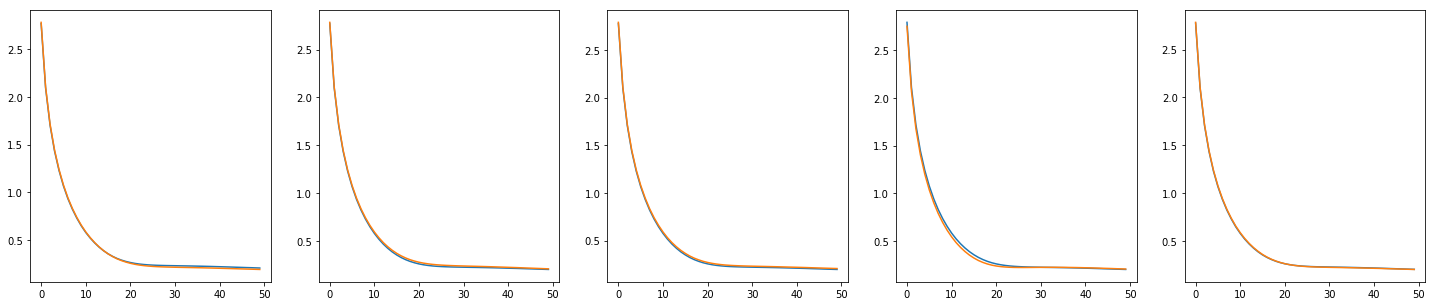

In [113]:
# 下面先根据经验赋值一组数据，验证上面模型和算法的可行性

k=5
epochs=50
learning_rate=5
weight_decay=0
units=0
dropout=0

train_avg_loss, test_avg_loss, train_avg_loss_std, test_avg_loss_std = k_fold_cross_valid(
    k, epochs, X_train, y_train, learning_rate, weight_decay, units, dropout, savejpg=False)

## **炼丹**

下面开始炼丹：目前的6个参数，可以有无数种组合，如何找到最佳的那个，开启格格巫模式。

In [114]:
# 排列组合
def expand(mulcoldf, sigcoldf):
    r = pd.DataFrame(columns=np.append(mulcoldf.columns.values, sigcoldf.columns.values))
    for x in sigcoldf.values:
        s = mulcoldf.copy()
        s[sigcoldf.columns[0]] = x[0]
        r = pd.concat([r,s])
    return r

# k,epochs,learning_rate,weight_decay,units,dropout
def get_params(k=[5],epochs=[50],learning_rate=[10,5,3,1],weight_decay=[0],units=[128],dropout=[0.1,0.01]):
    p = pd.DataFrame()
    p = expand(pd.DataFrame({'k':k}), pd.DataFrame({'epochs':epochs}))
    p = expand(p, pd.DataFrame({'learning_rate':learning_rate}))
    p = expand(p, pd.DataFrame({'weight_decay':weight_decay}))
    p = expand(p, pd.DataFrame({'units':units}))
    p = expand(p, pd.DataFrame({'dropout':dropout}))
    return p.reset_index(drop=True)

In [115]:
params = get_params(learning_rate=[0.1,0.5,1,2,3,4,5], weight_decay=[1,10,100,130,150,500], units=[64,128,256])
params[-5:]

,k,epochs,learning_rate,weight_decay,units,dropout
247,5,50,1.0,500,256,0.01
248,5,50,2.0,500,256,0.01
249,5,50,3.0,500,256,0.01
250,5,50,4.0,500,256,0.01
251,5,50,5.0,500,256,0.01


炼丹开始  
嘀嗒嘀嗒嘀嗒嘀嗒  
时针它不停在转动  
嘀嗒嘀嗒嘀嗒嘀嗒  
小雨她拍打着水花  

In [116]:
dfrult = pd.DataFrame(columns=('k','epochs','learning_rate','weight_decay','units','dropout','train_avg_loss','test_avg_loss','train_avg_loss_std','test_avg_loss_std'))
i = 0
for param in params.values:
    print("%s %d" % ("="*80,i))
    i += 1
    k,epochs,learning_rate,weight_decay,units,dropout = param.tolist()    
    print("k-fold=%d,epochs=%d,learning_rate=%f,weight_decay=%f,units=%d,dropout=%d" % (k,epochs,learning_rate,weight_decay,units,dropout))
    
    train_avg_loss, test_avg_loss, train_avg_loss_std, test_avg_loss_std = k_fold_cross_valid(k, epochs, X_train, y_train, learning_rate, weight_decay, units, dropout, savejpg=True)
    
    temp = pd.DataFrame([[k,epochs,learning_rate,weight_decay,units,dropout,train_avg_loss,test_avg_loss,train_avg_loss_std,test_avg_loss_std]],
                columns=['k','epochs','learning_rate','weight_decay','units','dropout','train_avg_loss','test_avg_loss','train_avg_loss_std','test_avg_loss_std'])
    dfrult = pd.concat([dfrult, temp])

================================================================================ 0
k-fold=5,epochs=50,learning_rate=0.100000,weight_decay=1.000000,units=64,dropout=0
1-fold 	Train loss:0.355041 	Test loss: 0.194274
2-fold 	Train loss:0.206892 	Test loss: 0.557436
3-fold 	Train loss:0.319858 	Test loss: 0.260306
4-fold 	Train loss:0.366705 	Test loss: 0.195398
5-fold 	Train loss:0.332685 	Test loss: 0.214387
5-fold Avg: train loss: 0.323109, Avg test loss: 0.286643, Avg train lost std: 0.067352, Avg test lost std: 0.050247
================================================================================ 1
k-fold=5,epochs=50,learning_rate=0.500000,weight_decay=1.000000,units=64,dropout=0
1-fold 	Train loss:0.121589 	Test loss: 0.122019
2-fold 	Train loss:0.124407 	Test loss: 0.141308
3-fold 	Train loss:0.128046 	Test loss: 0.142028
4-fold 	Train loss:0.131101 	Test loss: 0.131312
5-fold 	Train loss:0.138032 	Test loss: 0.146833
5-fold Avg: train loss: 0.136394, Avg test loss: 0.145344, Av

savejpg=True 会保存图片到指定位置，注意修改一下这个保存路径。如果正常的话，几百张图片已经在哪里等着了，每组超参一张图片，每张图片中k张图（k-折的k）。

分析一下炼丹炉出来的丹药：

In [117]:
df = dfrult.copy()

In [118]:
df[:5]

,k,epochs,learning_rate,weight_decay,units,dropout,train_avg_loss,test_avg_loss,train_avg_loss_std,test_avg_loss_std
0,5,50,0.1,1,64,0.1,0.323109,0.286643,0.067352,0.050247
0,5,50,0.5,1,64,0.1,0.136394,0.145344,0.061266,0.051623


In [119]:
df['diff'] = df['test_avg_loss'] - df['train_avg_loss']
df['sum'] = df['test_avg_loss'] + df['train_avg_loss']
df = df.sort_values('sum').reset_index(drop=True)
df[:5]

,k,epochs,learning_rate,weight_decay,units,dropout,train_avg_loss,test_avg_loss,train_avg_loss_std,test_avg_loss_std,diff,sum
0,5,50,0.5,1,64,0.1,0.136394,0.145344,0.061266,0.051623,0.008951,0.281738
1,5,50,0.1,1,64,0.1,0.323109,0.286643,0.067352,0.050247,-0.036466,0.609752


In [120]:
# 标杆
df.loc[df['learning_rate']==0.1].loc[df['weight_decay']==130].loc[df['units']==128].loc[df['dropout']==0.01]

,k,epochs,learning_rate,weight_decay,units,dropout,train_avg_loss,test_avg_loss,train_avg_loss_std,test_avg_loss_std,diff,sum


In [121]:
df[df['diff']<0.03][:5]

,k,epochs,learning_rate,weight_decay,units,dropout,train_avg_loss,test_avg_loss,train_avg_loss_std,test_avg_loss_std,diff,sum
0,5,50,0.5,1,64,0.1,0.136394,0.145344,0.061266,0.051623,0.008951,0.281738
1,5,50,0.1,1,64,0.1,0.323109,0.286643,0.067352,0.050247,-0.036466,0.609752


## **预测**

In [122]:
def learn(epochs, X_train, y_train, test, learning_rate, weight_decay, units, dropout):
    net = get_net(units=units, dropout=dropout)
    train_loss = train(net, X_train, y_train, None, None, epochs, learning_rate, weight_decay)
    plt.plot(train_loss)
    plt.show()
    print("train loss last 10 data avg: %f" % np.mean(train_loss[-10:]))
    preds = net(X_test).asnumpy()
    test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test['Id'], test['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

k-fold=5,epoches=50,learning_rate=0.500000,weight_decay=1.000000,units=64,dropout=0


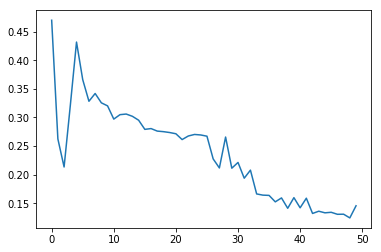

train loss last 10 data avg: 0.136928


In [123]:
# 选出那粒丹药
#k,epoches,learning_rate,weight_decay,units,dropout = (5,50,0.1,130,128,0.01)
k,epoches,learning_rate,weight_decay,units,dropout = df.iloc[0][0:6]
print("k-fold=%d,epoches=%d,learning_rate=%f,weight_decay=%f,units=%d,dropout=%d" % (k,epoches,learning_rate,weight_decay,units,dropout))

learn(epochs, X_train, y_train, df_test, learning_rate, weight_decay, units, dropout)

顺利的话，待提交 kaggle 的文件已经生成： submission.csv

使用命令行提交： `kaggle c submit -c house-prices-advanced-regression-techniques -f submission.csv -m "I love kaggle"` 

祝你和我一样，也能进入前100名。

Good luck！